In [1]:
import pandas as pd

# =========================
# 1. CONFIGURATION
# =========================
INPUT_FILE = 'model_ready_dataset.parquet'

# =========================
# 2. LOAD THE CLEAN DATASET
# =========================
print(f"--- Loading the clean, model-ready dataset: {INPUT_FILE} ---")
df = pd.read_parquet(INPUT_FILE)
df['T_REC'] = pd.to_datetime(df['T_REC'])
print(f"Successfully loaded {len(df)} records.")

# =========================
# 3. PERFORM CHRONOLOGICAL SPLIT
# =========================
print("\n--- Performing chronological split (Train on 2014, Test on 2015) ---")

train_df = df[df['T_REC'].dt.year == 2014].copy()
test_df = df[df['T_REC'].dt.year == 2015].copy()

# =========================
# 4. SEPARATE FEATURES (X) AND LABELS (y)
# =========================
print("\n--- Separating features (X) from labels (y) ---")

# Define your feature columns (everything except identifiers and labels)
feature_cols = [col for col in df.columns if col not in ['T_REC', 'HARPNUM', 'NOAA_AR', 'classification', 'flare']]
target_col = 'flare' # Using the binary 0/1 label

# Create the final training and testing sets
X_train = train_df[feature_cols]
y_train = train_df[target_col]

X_test = test_df[feature_cols]
y_test = test_df[target_col]

# =========================
# 5. VERIFY THE SPLIT
# =========================
print("\n--- Verification ---")
print(f"Training features shape: {X_train.shape}")
print(f"Training labels shape:   {y_train.shape}")
print(f"Testing features shape:  {X_test.shape}")
print(f"Testing labels shape:    {y_test.shape}")

# Optional: Save the split datasets for easy access later
# X_train.to_parquet('X_train.parquet')
# y_train.to_parquet('y_train.parquet')
# X_test.to_parquet('X_test.parquet')
# y_test.to_parquet('y_test.parquet')

print("\n✅ Data splitting complete. You are now ready to train your models.")

--- Loading the clean, model-ready dataset: model_ready_dataset.parquet ---
Successfully loaded 346228 records.

--- Performing chronological split (Train on 2014, Test on 2015) ---

--- Separating features (X) from labels (y) ---

--- Verification ---
Training features shape: (171782, 17)
Training labels shape:   (171782,)
Testing features shape:  (174444, 17)
Testing labels shape:    (174444,)

✅ Data splitting complete. You are now ready to train your models.


In [4]:
import pandas as pd
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# =========================
# 1. LOAD AND SPLIT DATA
# =========================
print("--- Loading the model-ready dataset ---")
df = pd.read_parquet('model_ready_dataset.parquet')
df['T_REC'] = pd.to_datetime(df['T_REC'])

# Create the chronological split
train_df = df[df['T_REC'].dt.year == 2014].copy()
test_df = df[df['T_REC'].dt.year == 2015].copy()

# Separate features (X) and labels (y)
feature_cols = [col for col in df.columns if col not in ['T_REC', 'HARPNUM', 'NOAA_AR', 'classification', 'flare']]
target_col = 'flare'

X_train = train_df[feature_cols]
y_train = train_df[target_col]
X_test = test_df[feature_cols]
y_test = test_df[target_col]

print(f"Training on {len(train_df)} records, testing on {len(test_df)} records.")

# =========================
# 2. TRAIN RANDOM FOREST
# =========================
print("\n\n--- Training RandomForest Classifier ---")
rf_model = RandomForestClassifier(
    n_estimators=100,
    class_weight='balanced', # Handles class imbalance
    n_jobs=-1,
    random_state=42
)
rf_model.fit(X_train, y_train)
print("--- RandomForest training complete! ---")

print("\n--- RandomForest Evaluation ---")
y_pred_rf = rf_model.predict(X_test)
print("\nConfusion Matrix (RandomForest):")
print(confusion_matrix(y_test, y_pred_rf))
print("\nClassification Report (RandomForest):")
print(classification_report(y_test, y_pred_rf, target_names=['Non-flare (0)', 'Flare (1)']))


# =========================
# 3. TRAIN XGBOOST
# =========================
print("\n\n--- Training XGBoost Classifier ---")

# --- Handle Class Imbalance for XGBoost ---
# Calculate scale_pos_weight = (count of negative class) / (count of positive class)
label_counts = y_train.value_counts()
scale_pos_weight = label_counts[0] / label_counts[1]
print(f"Calculated scale_pos_weight for XGBoost: {scale_pos_weight:.2f}")

xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    scale_pos_weight=scale_pos_weight, # Use the calculated weight
    use_label_encoder=False,
    random_state=42
)
xgb_model.fit(X_train, y_train)
print("--- XGBoost training complete! ---")

print("\n--- XGBoost Evaluation ---")
y_pred_xgb = xgb_model.predict(X_test)
print("\nConfusion Matrix (XGBoost):")
print(confusion_matrix(y_test, y_pred_xgb))
print("\nClassification Report (XGBoost):")
print(classification_report(y_test, y_pred_xgb, target_names=['Non-flare (0)', 'Flare (1)']))

C:\Users\uav18\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:37: UserWarning: A NumPy version >=1.23.5 and <2.3.0 is required for this version of SciPy (detected version 2.3.2)
  import scipy.sparse


--- Loading the model-ready dataset ---
Training on 171782 records, testing on 174444 records.


--- Training RandomForest Classifier ---
--- RandomForest training complete! ---

--- RandomForest Evaluation ---

Confusion Matrix (RandomForest):
[[174351     93]
 [     0      0]]

Classification Report (RandomForest):


C:\Users\uav18\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\uav18\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\uav18\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

               precision    recall  f1-score   support

Non-flare (0)       1.00      1.00      1.00    174444
    Flare (1)       0.00      0.00      0.00         0

     accuracy                           1.00    174444
    macro avg       0.50      0.50      0.50    174444
 weighted avg       1.00      1.00      1.00    174444



--- Training XGBoost Classifier ---
Calculated scale_pos_weight for XGBoost: 149.29


C:\Users\uav18\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:08:30] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


--- XGBoost training complete! ---

--- XGBoost Evaluation ---

Confusion Matrix (XGBoost):
[[174164    280]
 [     0      0]]

Classification Report (XGBoost):
               precision    recall  f1-score   support

Non-flare (0)       1.00      1.00      1.00    174444
    Flare (1)       0.00      0.00      0.00         0

     accuracy                           1.00    174444
    macro avg       0.50      0.50      0.50    174444
 weighted avg       1.00      1.00      1.00    174444



C:\Users\uav18\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\uav18\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\uav18\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

In [6]:
import pandas as pd
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

# =========================
# 1. LOAD DATA
# =========================
print("--- Loading the model-ready dataset ---")
df = pd.read_parquet('model_ready_dataset.parquet')
df['T_REC'] = pd.to_datetime(df['T_REC'])

# =========================
# 2. PERFORM ROBUST SPLIT BY ACTIVE REGION
# =========================
print("\n--- Performing split by Active Region to ensure flares are in the test set ---")

# Find all ARs that produced at least one M or X flare
flaring_ars = df[df['flare'] == 1]['NOAA_AR'].unique()

# Split the list of flaring ARs into train and test groups
train_ars, test_ars = train_test_split(flaring_ars, test_size=0.2, random_state=42)

# Create the training set: all data from the training ARs
train_df = df[df['NOAA_AR'].isin(train_ars)].copy()

# Create the test set: all data from the testing ARs
test_df = df[df['NOAA_AR'].isin(test_ars)].copy()

# Add non-flaring ARs to the training set to ensure the model sees "quiet" sunspots
non_flaring_ars = df[df['flare'] == 0]['NOAA_AR'].unique()
# Exclude any that might have also appeared in the test set (unlikely but possible)
non_flaring_ars_train = [ar for ar in non_flaring_ars if ar not in test_ars]
train_df = pd.concat([train_df, df[df['NOAA_AR'].isin(non_flaring_ars_train)]]).drop_duplicates()

# Sort by time, as is good practice
train_df.sort_values('T_REC', inplace=True)
test_df.sort_values('T_REC', inplace=True)

# =========================
# 3. SEPARATE FEATURES AND LABELS
# =========================
feature_cols = [col for col in df.columns if col not in ['T_REC', 'HARPNUM', 'NOAA_AR', 'classification', 'flare']]
target_col = 'flare'

X_train = train_df[feature_cols]
y_train = train_df[target_col]
X_test = test_df[feature_cols]
y_test = test_df[target_col]

print(f"Training on {len(train_df)} records, testing on {len(test_df)} records.")
print(f"Number of positive flare samples in Test Set: {y_test.sum()}")


# =========================
# 4. TRAIN AND EVALUATE MODELS
# =========================
# (The RandomForest and XGBoost training code from here is the same as before)

# --- RandomForest ---
print("\n\n--- Training RandomForest Classifier ---")
rf_model = RandomForestClassifier(n_estimators=100, class_weight='balanced', n_jobs=-1, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
print("\nConfusion Matrix (RandomForest):\n", confusion_matrix(y_test, y_pred_rf))
print("\nClassification Report (RandomForest):\n", classification_report(y_test, y_pred_rf))

# --- XGBoost ---
print("\n\n--- Training XGBoost Classifier ---")
label_counts = y_train.value_counts()
scale_pos_weight = label_counts.get(0, 0) / label_counts.get(1, 1)
print(f"Calculated scale_pos_weight for XGBoost: {scale_pos_weight:.2f}")
xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', scale_pos_weight=scale_pos_weight, use_label_encoder=False, random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
print("\nConfusion Matrix (XGBoost):\n", confusion_matrix(y_test, y_pred_xgb))
print("\nClassification Report (XGBoost):\n", classification_report(y_test, y_pred_xgb))

--- Loading the model-ready dataset ---

--- Performing split by Active Region to ensure flares are in the test set ---
Training on 341663 records, testing on 4565 records.
Number of positive flare samples in Test Set: 299


--- Training RandomForest Classifier ---

Confusion Matrix (RandomForest):
 [[4266    0]
 [ 299    0]]

Classification Report (RandomForest):
               precision    recall  f1-score   support

           0       0.93      1.00      0.97      4266
           1       0.00      0.00      0.00       299

    accuracy                           0.93      4565
   macro avg       0.47      0.50      0.48      4565
weighted avg       0.87      0.93      0.90      4565



--- Training XGBoost Classifier ---
Calculated scale_pos_weight for XGBoost: 403.81


C:\Users\uav18\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\uav18\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\uav18\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo


Confusion Matrix (XGBoost):
 [[4266    0]
 [ 299    0]]

Classification Report (XGBoost):
               precision    recall  f1-score   support

           0       0.93      1.00      0.97      4266
           1       0.00      0.00      0.00       299

    accuracy                           0.93      4565
   macro avg       0.47      0.50      0.48      4565
weighted avg       0.87      0.93      0.90      4565



C:\Users\uav18\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\uav18\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\uav18\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [3]:
import pandas as pd
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

def calculate_tss(y_true, y_pred):
    """Calculates the True Skill Statistic (TSS)."""
    try:
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        tpr = tp / (tp + fn)
        fpr = fp / (fp + tn)
        return tpr - fpr
    except ValueError:
        return 0.0

# =========================
# 1. LOAD AND SPLIT DATA
# =========================
print("--- Loading the feature-engineered dataset ---")
df = pd.read_parquet('model_ready_feature_engineered.parquet')
df['T_REC'] = pd.to_datetime(df['T_REC'])

# Perform split by Active Region
print("\n--- Performing split by Active Region ---")
flaring_ars = df[df['flare'] == 1]['NOAA_AR'].unique()
train_ars, test_ars = train_test_split(flaring_ars, test_size=0.2, random_state=42)
train_df = df[df['NOAA_AR'].isin(train_ars)].copy()
test_df = df[df['NOAA_AR'].isin(test_ars)].copy()
non_flaring_ars = df[df['flare'] == 0]['NOAA_AR'].unique()
non_flaring_ars_train = [ar for ar in non_flaring_ars if ar not in test_ars]
train_df = pd.concat([train_df, df[df['NOAA_AR'].isin(non_flaring_ars_train)]]).drop_duplicates()
train_df.sort_values('T_REC', inplace=True)
test_df.sort_values('T_REC', inplace=True)

# Separate features and labels
feature_cols = [col for col in df.columns if col not in ['T_REC', 'HARPNUM', 'NOAA_AR', 'classification', 'flare']]
target_col = 'flare'
X_train, y_train = train_df[feature_cols], train_df[target_col]
X_test, y_test = test_df[feature_cols], test_df[target_col]

print(f"Original training set shape: {X_train.shape}")

# =========================
# 2. APPLY SMOTE TO THE TRAINING DATA
# =========================
print("\n--- Applying SMOTE to balance the training data ---")
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
print(f"Resampled training set shape: {X_train_resampled.shape}")

# =========================
# 3. TRAIN XGBOOST ON THE BALANCED DATA
# =========================
print("\n\n--- Training XGBoost Classifier on SMOTE data ---")
# With a balanced dataset, we no longer need scale_pos_weight
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    use_label_encoder=False,
    random_state=42
)
xgb_model.fit(X_train_resampled, y_train_resampled)
print("--- XGBoost training complete! ---")

# =========================
# 4. EVALUATE ON THE ORIGINAL, UNSEEN TEST SET
# =========================
y_pred_xgb = xgb_model.predict(X_test)
print("\n--- XGBoost Evaluation ---")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))
print("\nClassification Report:\n", classification_report(y_test, y_pred_xgb))
print(f"\nTrue Skill Statistic (TSS): {calculate_tss(y_test, y_pred_xgb):.4f}")

--- Loading the feature-engineered dataset ---

--- Performing split by Active Region ---
Original training set shape: (320564, 49)

--- Applying SMOTE to balance the training data ---
Resampled training set shape: (639268, 49)


--- Training XGBoost Classifier on SMOTE data ---


C:\Users\uav18\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:20:39] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


--- XGBoost training complete! ---

--- XGBoost Evaluation ---
Confusion Matrix:
 [[2842   10]
 [ 179    0]]

Classification Report:
               precision    recall  f1-score   support

           0       0.94      1.00      0.97      2852
           1       0.00      0.00      0.00       179

    accuracy                           0.94      3031
   macro avg       0.47      0.50      0.48      3031
weighted avg       0.89      0.94      0.91      3031


True Skill Statistic (TSS): -0.0035


In [3]:
import pandas as pd
import glob

# =========================
# CONFIGURATION
# =========================
FEATURED_FILE = "final_labeled_2014-2015_dataset.parquet"   # your feature-engineered dataset
FLARE_FILE = "raw_flare_data_parquet/*.parquet"         # path to flare parquet files
YEAR_START = "2014-01-01"
YEAR_END   = "2015-12-31"

# =========================
# 1. LOAD DATA
# =========================
print("\n--- Loading data ---")
df = pd.read_parquet(FEATURED_FILE)

flares = pd.concat(
    pd.read_parquet(f) for f in glob.glob(FLARE_FILE)
)
# Convert time and filter only 2014–2015
flares['event_starttime'] = pd.to_datetime(flares['event_starttime'], errors='coerce')
flares = flares[
    (flares['event_starttime'] >= YEAR_START) &
    (flares['event_starttime'] <= YEAR_END)
].copy()

print(f"Dataset has {len(df)} rows, with {df['flare'].sum()} positives.")
print(f"Flare catalog (2014–2015) has {len(flares)} events.")

# =========================
# 2. CHECK POSITIVE SAMPLES
# =========================
positives = df[df['flare'] == 1].copy()
if positives.empty:
    print("\n⚠ No positive samples found in dataset! Labeling issue suspected.")
else:
    print(f"\nFound {len(positives)} positive samples. Previewing 5:")
    print(positives[['T_REC','NOAA_AR','classification']].head())

# =========================
# 3. VERIFY MATCH WITH FLARE CATALOG (2014–2015)
# =========================
# Convert SHARP times just in case
positives['T_REC'] = pd.to_datetime(positives['T_REC'], errors='coerce')

print("\n--- Cross-checking positives with flare catalog (2014–2015) ---")
for i, row in positives.head(5).iterrows():
    ar = row['NOAA_AR']
    t = row['T_REC']
    
    # Find flares for this AR near this timestamp (±24h window)
    nearby = flares[
        (flares['ar_noaanum'] == ar) &
        (flares['event_starttime'] >= t) &
        (flares['event_starttime'] <= t + pd.Timedelta(hours=24))
    ]
    
    print(f"\nSample: HARPNUM={row['HARPNUM']}, NOAA_AR={ar}, T_REC={t}, Label={row['classification']}")
    if not nearby.empty:
        print("  ✅ Matched flares in catalog:")
        print(nearby[['event_starttime','fl_goescls','ar_noaanum']])
    else:
        print("  ❌ No matching flare found in catalog (possible labeling issue).")


--- Loading data ---
Dataset has 681458 rows, with 1143 positives.
Flare catalog (2014–2015) has 2299 events.

Found 1143 positive samples. Previewing 5:
                  T_REC  NOAA_AR classification
121 2014-01-04 00:00:00    11936              M
122 2014-01-04 00:12:00    11936              M
123 2014-01-04 00:24:00    11936              M
124 2014-01-04 00:36:00    11936              M
125 2014-01-04 00:48:00    11936              M

--- Cross-checking positives with flare catalog (2014–2015) ---

Sample: HARPNUM=3535, NOAA_AR=11936, T_REC=2014-01-04 00:00:00, Label=M
  ✅ Matched flares in catalog:
      event_starttime fl_goescls  ar_noaanum
6 2014-01-04 22:12:00       M1.9       11936

Sample: HARPNUM=3535, NOAA_AR=11936, T_REC=2014-01-04 00:12:00, Label=M
  ✅ Matched flares in catalog:
      event_starttime fl_goescls  ar_noaanum
6 2014-01-04 22:12:00       M1.9       11936

Sample: HARPNUM=3535, NOAA_AR=11936, T_REC=2014-01-04 00:24:00, Label=M
  ✅ Matched flares in catalog:


In [1]:
# balanced_training_pipeline.py
# Run this with: python balanced_training_pipeline.py
# Requires: pandas, numpy, scikit-learn, xgboost, imbalanced-learn, joblib, matplotlib (optional)

import os
import numpy as np
import pandas as pd
from sklearn.model_selection import GroupShuffleSplit, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    average_precision_score, roc_curve
)
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from imblearn.ensemble import BalancedRandomForestClassifier
import joblib
import warnings
warnings.filterwarnings("ignore")

# --------------------------
# CONFIG
# --------------------------
DATA_FILE = "model_ready_feature_engineered.parquet"   # change to your file, or .csv
GROUP_COL = "HARPNUM"                      # or 'NOAA_AR' if you prefer grouping by NOAA
TIME_COL = "T_REC"                         # must be parseable datetimes
LABEL_COL = "flare"                        # binary target (0/1)
CLASS_COLNAME = "classification"           # multiclass if needed
TEST_GROUP_FRAC = 0.10                     # fraction of groups assigned to test
RANDOM_STATE = 42

# --------------------------
# UTIL: time parsing (safe)
# --------------------------
def parse_times_safe(series):
    """
    Handle common timestamp formats in your SHARP data:
     - epoch ms integers
     - 'YYYY.MM.DD_HH:MM:SS_TAI' strings
     - plain ISO strings
    Returns a datetime64[ns] series in UTC (approx for TAI by subtracting 37s).
    """
    s = pd.Series(series).astype(object)
    # Numeric epoch-ms (very large ints)
    if pd.api.types.is_integer_dtype(s) or pd.api.types.is_float_dtype(s):
        # try ms -> if too small, try seconds
        median = np.nanmedian(s.dropna().astype(float))
        if median > 1e12:
            return pd.to_datetime(s, unit='ms', errors='coerce', utc=True)
        elif median > 1e9:
            return pd.to_datetime(s, unit='s', errors='coerce', utc=True)
        else:
            return pd.to_datetime(s, errors='coerce', utc=True)

    # strings
    s_str = s.astype(str)

    # TAI pattern like '2013.01.01_00:00:00_TAI' -> make '2013-01-01 00:00:00' then subtract ~37s
    if s_str.str.contains("_TAI").any():
        cleaned = s_str.str.replace("_TAI", "", regex=False)
        # replace yyyy.mm.dd_hh:mm:ss → yyyy-mm-dd hh:mm:ss
        cleaned = cleaned.str.replace(r"^(\d{4})\.(\d{2})\.(\d{2})_(\d{2}:\d{2}:\d{2})$",
                                      r"\1-\2-\3 \4", regex=True)
        dt = pd.to_datetime(cleaned, errors='coerce', utc=True)
        # approximate TAI -> UTC (TAI − UTC ≈ 37s in 2014 era). This is an approximation.
        dt = dt - pd.to_timedelta(37, unit='s')
        return dt

    # fallback: natural parsing
    return pd.to_datetime(s_str, errors='coerce', utc=True)


# --------------------------
# 1. LOAD DATA
# --------------------------
print("\n--- Loading dataset ---")
if DATA_FILE.endswith(".parquet"):
    df = pd.read_parquet(DATA_FILE)
else:
    df = pd.read_csv(DATA_FILE)

print(f"Loaded dataset with {len(df):,} rows and columns: {list(df.columns)}")

# --------------------------
# 2. TIME parse and filter
# --------------------------
print("\n--- Parsing time column ---")
if TIME_COL not in df.columns:
    raise KeyError(f"Time column '{TIME_COL}' not found in data")

df[TIME_COL] = parse_times_safe(df[TIME_COL])
df = df.dropna(subset=[TIME_COL])  # drop rows with unparseable time
df[TIME_COL] = pd.to_datetime(df[TIME_COL])  # ensure tz-naive for grouping/filters

# --------------------------
# 3. LABEL CHECK
# --------------------------
if LABEL_COL not in df.columns:
    raise KeyError(f"Label column '{LABEL_COL}' not found in data")

df[LABEL_COL] = pd.to_numeric(df[LABEL_COL], errors='coerce').fillna(0).astype(int)
pos = df[LABEL_COL].sum()
neg = len(df) - pos
print(f"\nLabel distribution: positives={pos:,}, negatives={neg:,} (pos rate={pos/len(df):.4f})")

if pos == 0:
    raise ValueError("No positive samples found — cannot train. Check labels.")

# --------------------------
# 4. CHOOSE GROUP COLUMN
# --------------------------
if GROUP_COL not in df.columns:
    # try NOAA_AR fallback
    if "NOAA_AR" in df.columns:
        GROUP_COL = "NOAA_AR"
        print("GROUP_COL not found; using NOAA_AR instead")
    else:
        raise KeyError(f"Group column '{GROUP_COL}' not found and NOAA_AR not present.")

print(f"Grouping by '{GROUP_COL}' for split (prevents leakage). Unique groups: {df[GROUP_COL].nunique():,}")

# --------------------------
# 5. Group-aware split (train/test)
# --------------------------
print("\n--- Splitting groups into train/test ---")
groups = df[GROUP_COL].values
unique_groups = np.unique(groups)
rng = np.random.RandomState(RANDOM_STATE)
# shuffle unique groups
rng.shuffle(unique_groups)
n_test_groups = max(1, int(len(unique_groups) * TEST_GROUP_FRAC))
test_groups = set(unique_groups[:n_test_groups])
train_mask = ~df[GROUP_COL].isin(test_groups)
test_mask = df[GROUP_COL].isin(test_groups)
train_df = df[train_mask].copy()
test_df = df[test_mask].copy()
print(f"Train rows: {len(train_df):,}  Test rows: {len(test_df):,}")
print(f"Train positives: {train_df[LABEL_COL].sum():,}  Test positives: {test_df[LABEL_COL].sum():,}")

if test_df[LABEL_COL].sum() == 0:
    print("Warning: test set has ZERO positives. Consider lowering TEST_GROUP_FRAC or ensuring groups with flares are in test set.")
    # fallback: try to ensure at least one positive group in test
    # (We'll continue but it's a warning)

# --------------------------
# 6. Feature selection
# --------------------------
print("\n--- Selecting features ---")
# Auto-select numeric columns and exclude identifier/time/labels
exclude = {GROUP_COL, TIME_COL, LABEL_COL, CLASS_COLNAME,'NOAA_AR'}
feat_cols = [c for c in train_df.columns if c not in exclude and
             pd.api.types.is_numeric_dtype(train_df[c])]

# Make sure there are features
if len(feat_cols) == 0:
    raise ValueError("No numeric feature columns were found. Edit 'feat_cols' manually.")

print(f"Using {len(feat_cols)} features. Example: {feat_cols[::]}")

X_train = train_df[feat_cols].values
y_train = train_df[LABEL_COL].values
X_test = test_df[feat_cols].values
y_test = test_df[LABEL_COL].values

# --------------------------
# 7. Standardize
# --------------------------
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# --------------------------
# Helper: evaluate & threshold tune (TSS)
# --------------------------
def evaluate_with_thresholds(model, X_test, y_test, return_details=False):
    probs = model.predict_proba(X_test)[:, 1]
    roc_auc = roc_auc_score(y_test, probs) if len(np.unique(y_test)) > 1 else np.nan
    pr_auc = average_precision_score(y_test, probs) if len(np.unique(y_test)) > 1 else np.nan
    fpr, tpr, thr = roc_curve(y_test, probs, pos_label=1)
    tss_scores = tpr - fpr
    best_idx = np.nanargmax(tss_scores)
    best_thresh = thr[best_idx]
    # predictions at best threshold
    y_pred = (probs >= best_thresh).astype(int)
    cm = confusion_matrix(y_test, y_pred)
    report = classification_report(y_test, y_pred, zero_division=0)
    results = {
        "roc_auc": roc_auc,
        "pr_auc": pr_auc,
        "best_threshold": float(best_thresh),
        "tss": float(tss_scores[best_idx]),
        "confusion_matrix": cm,
        "classification_report": report
    }
    if return_details:
        return results, probs, (fpr, tpr, thr)
    return results

# --------------------------
# 8. Strategy A: XGBoost with scale_pos_weight (no resampling)
# --------------------------
print("\n=== Strategy A: XGBoost (scale_pos_weight) ===")
n_pos = y_train.sum()
n_neg = len(y_train) - n_pos
scale_pos_weight = max(1.0, n_neg / (n_pos + 1e-9))
model_a = XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.05,
    use_label_encoder=False,
    eval_metric="logloss",
    scale_pos_weight=scale_pos_weight,
    n_jobs=-1,
    random_state=RANDOM_STATE
)
model_a.fit(X_train, y_train)
res_a = evaluate_with_thresholds(model_a, X_test, y_test, return_details=False)
print("Scale_pos_weight:", scale_pos_weight)
print("Best threshold (TSS):", res_a["best_threshold"])
print("TSS:", res_a["tss"])
print("ROC AUC:", res_a["roc_auc"])
print("PR AUC:", res_a["pr_auc"])
print("Confusion Matrix:\n", res_a["confusion_matrix"])
print("\nClassification report:\n", res_a["classification_report"])

# --------------------------
# 9. Strategy B: SMOTE on training data + XGBoost
# --------------------------
print("\n=== Strategy B: SMOTE (oversample train) + XGBoost ===")
try:
    # dynamic k_neighbors: ensure at least 1
    from imblearn.over_sampling import SMOTE
    k_neighbors = 5
    if n_pos < 6:
        k_neighbors = max(1, n_pos - 1)
    sm = SMOTE(random_state=RANDOM_STATE, k_neighbors=k_neighbors)
    X_res, y_res = sm.fit_resample(X_train, y_train)
    print("Resampled train shape:", X_res.shape, y_res.sum(), "positives")
    model_b = XGBClassifier(
        n_estimators=200,
        max_depth=6,
        learning_rate=0.05,
        use_label_encoder=False,
        eval_metric="logloss",
        n_jobs=-1,
        random_state=RANDOM_STATE
    )
    model_b.fit(X_res, y_res)
    res_b = evaluate_with_thresholds(model_b, X_test, y_test, return_details=False)
    print("Best threshold (TSS):", res_b["best_threshold"])
    print("TSS:", res_b["tss"])
    print("ROC AUC:", res_b["roc_auc"])
    print("PR AUC:", res_b["pr_auc"])
    print("Confusion Matrix:\n", res_b["confusion_matrix"])
    print("\nClassification report:\n", res_b["classification_report"])
except Exception as e:
    print("SMOTE failed:", e)
    res_b = None

# --------------------------
# 10. Strategy C: BalancedRandomForest (ensemble undersampling)
# --------------------------
print("\n=== Strategy C: BalancedRandomForest (built-in balancing) ===")
try:
    brf = BalancedRandomForestClassifier(
        n_estimators=200,
        sampling_strategy="auto",
        replacement=False,
        n_jobs=-1,
        random_state=RANDOM_STATE
    )
    brf.fit(X_train, y_train)
    res_c = evaluate_with_thresholds(brf, X_test, y_test, return_details=False)
    print("Best threshold (TSS):", res_c["best_threshold"])
    print("TSS:", res_c["tss"])
    print("ROC AUC:", res_c["roc_auc"])
    print("PR AUC:", res_c["pr_auc"])
    print("Confusion Matrix:\n", res_c["confusion_matrix"])
    print("\nClassification report:\n", res_c["classification_report"])
except Exception as e:
    print("BalancedRandomForest failed:", e)
    res_c = None

# --------------------------
# 11. Pick best model by TSS and save
# --------------------------
results = []
if res_a: results.append(("xgb_scale", res_a, model_a))
if res_b: results.append(("xgb_smote", res_b, model_b))
if res_c: results.append(("brf", res_c, brf))

best = None
best_tss = -999
for name, r, m in results:
    if r["tss"] > best_tss:
        best_tss = r["tss"]
        best = (name, r, m)
if best:
    name, r, m = best
    print(f"\n=== Best strategy: {name} with TSS={r['tss']:.4f} ===")
    joblib.dump({"model": m, "scaler": scaler, "features": feat_cols}, f"best_model_{name}.joblib")
    print("Saved best model to:", f"best_model_{name}_new.joblib")
else:
    print("No successful models to save.")

print("\nDone. Suggested next steps:")
print(" - If TSS/recall still near 0: try EasyEnsemble or change features / temporal aggregation.")
print(" - Inspect feature distributions between positive/negative samples (histograms/boxplots).")
print(" - Try changing prediction window to 6/12 hours; some flares have subtle precursors.")
print(" - Consider adding physics-derived features or time-aggregated stats (max/min/std over 6-12h).")


--- Loading dataset ---
Loaded dataset with 323,595 rows and columns: ['T_REC', 'HARPNUM', 'NOAA_AR', 'USFLUX', 'MEANGAM', 'MEANGBT', 'MEANGBZ', 'MEANGBH', 'TOTUSJH', 'TOTPOT', 'MEANPOT', 'TOTUSJZ', 'SAVNCPP', 'ABSNJZH', 'AREA_ACR', 'MEANJZH', 'R_VALUE', 'LAT_FWT', 'MEANALP', 'MEANSHR', 'classification', 'flare', 'USFLUX_d6h', 'USFLUX_d12h', 'MEANGAM_d6h', 'MEANGAM_d12h', 'MEANGBT_d6h', 'MEANGBT_d12h', 'MEANGBZ_d6h', 'MEANGBZ_d12h', 'MEANGBH_d6h', 'MEANGBH_d12h', 'TOTUSJH_d6h', 'TOTUSJH_d12h', 'TOTPOT_d6h', 'TOTPOT_d12h', 'MEANPOT_d6h', 'MEANPOT_d12h', 'TOTUSJZ_d6h', 'TOTUSJZ_d12h', 'SAVNCPP_d6h', 'SAVNCPP_d12h', 'ABSNJZH_d6h', 'ABSNJZH_d12h', 'AREA_ACR_d6h', 'AREA_ACR_d12h', 'MEANJZH_d6h', 'MEANJZH_d12h', 'R_VALUE_d6h', 'R_VALUE_d12h', 'MEANALP_d6h', 'MEANALP_d12h', 'MEANSHR_d6h', 'MEANSHR_d12h']

--- Parsing time column ---

Label distribution: positives=1,109, negatives=322,486 (pos rate=0.0034)
Grouping by 'HARPNUM' for split (prevents leakage). Unique groups: 386

--- Splitting g

In [5]:
"""
threshold_sweep_addon.py
Analyze decision thresholds for an existing trained model (joblib).
Does NOT overwrite your saved model.
"""

import os
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_curve, confusion_matrix, precision_score,
    recall_score, roc_auc_score, average_precision_score
)

# ---------------- CONFIG ----------------
DATA_FILE = "model_ready_feature_engineered.parquet"        # same dataset as training
MODEL_FILE = "best_model_brf.joblib"            # or your XGB joblib
GROUP_COL = "HARPNUM"
TIME_COL = "T_REC"
LABEL_COL = "flare"
THRESHOLDS = np.linspace(0.0, 1.0, 201)         # sweep range
OUT_DIR = "threshold_sweep_results"
os.makedirs(OUT_DIR, exist_ok=True)

# --------------- LOAD -------------------
print("\n--- Loading model ---")
saved = joblib.load(MODEL_FILE)
if isinstance(saved, dict):
    model = saved["model"]
    scaler = saved.get("scaler", None)
    feat_cols = saved.get("features", None)
else:
    raise ValueError("Saved joblib must be dict with keys: 'model','scaler','features'")

print(f"Loaded model from {MODEL_FILE}")

print("\n--- Loading dataset ---")
if DATA_FILE.endswith(".parquet"):
    df = pd.read_parquet(DATA_FILE)
else:
    df = pd.read_csv(DATA_FILE)

print(f"Dataset: {len(df):,} rows, {df[LABEL_COL].sum()} positives")

# features
if feat_cols is None:
    raise ValueError("Joblib did not save feature list. Cannot align features.")
X = df[feat_cols].values
y = df[LABEL_COL].values
if scaler:
    X = scaler.transform(X)

# get probabilities
print("\n--- Predicting probabilities ---")
if hasattr(model, "predict_proba"):
    probs = model.predict_proba(X)[:, 1]
else:
    # fallback (some BRF impl might not expose proba — then use decision_function)
    probs = model.decision_function(X)

print("ROC AUC:", roc_auc_score(y, probs))
print("PR AUC:", average_precision_score(y, probs))

# --------------- SWEEP -------------------
def evaluate_thresholds(y_true, probs, thresholds):
    rows = []
    for thr in thresholds:
        preds = (probs >= thr).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, preds, labels=[0,1]).ravel()
        prec = precision_score(y_true, preds, zero_division=0)
        rec = recall_score(y_true, preds, zero_division=0)
        tpr = tp / (tp + fn) if (tp+fn)>0 else 0.0
        fpr = fp / (fp + tn) if (fp+tn)>0 else 0.0
        tss = tpr - fpr
        rows.append({
            "threshold": thr, "tp": tp, "tn": tn, "fp": fp, "fn": fn,
            "precision": prec, "recall": rec, "tpr": tpr, "fpr": fpr, "tss": tss
        })
    return pd.DataFrame(rows)

df_thr = evaluate_thresholds(y, probs, THRESHOLDS)

# find best TSS
best_row = df_thr.loc[df_thr['tss'].idxmax()]
print("\nBest TSS threshold:", best_row["threshold"])
print("TSS:", best_row["tss"], "FP:", best_row["fp"], "FN:", best_row["fn"])

# save CSV
csv_path = os.path.join(OUT_DIR, "threshold_metrics.csv")
df_thr.to_csv(csv_path, index=False)
print("Saved threshold metrics CSV to", csv_path)

# plots
plt.figure(figsize=(8,5))
plt.plot(df_thr['threshold'], df_thr['tss'])
plt.axvline(best_row['threshold'], ls="--", color="r")
plt.xlabel("Threshold"); plt.ylabel("TSS")
plt.title("TSS vs Threshold"); plt.grid(True)
plt.tight_layout(); plt.savefig(os.path.join(OUT_DIR,"tss_vs_threshold.png"))
plt.close()

plt.figure(figsize=(8,5))
plt.plot(df_thr['threshold'], df_thr['precision'], label="Precision")
plt.plot(df_thr['threshold'], df_thr['recall'], label="Recall")
plt.xlabel("Threshold"); plt.ylabel("Score")
plt.title("Precision/Recall vs Threshold"); plt.legend(); plt.grid(True)
plt.tight_layout(); plt.savefig(os.path.join(OUT_DIR,"precision_recall_vs_threshold.png"))
plt.close()

plt.figure(figsize=(8,5))
plt.plot(df_thr['threshold'], df_thr['fp'], label="False Positives")
plt.plot(df_thr['threshold'], df_thr['fn'], label="False Negatives")
plt.xlabel("Threshold"); plt.ylabel("Count")
plt.title("FP / FN vs Threshold"); plt.legend(); plt.grid(True)
plt.tight_layout(); plt.savefig(os.path.join(OUT_DIR,"fp_fn_vs_threshold.png"))
plt.close()

print(f"Saved plots into {OUT_DIR}/")
print("\nSample rows:\n", df_thr.head(10).to_string(index=False))


--- Loading model ---
Loaded model from best_model_brf.joblib

--- Loading dataset ---
Dataset: 323,595 rows, 1109 positives

--- Predicting probabilities ---
ROC AUC: 0.9717140669577413
PR AUC: 0.7971192053780907

Best TSS threshold: 0.995
TSS: 0.7917011371424925 FP: 1.0 FN: 231.0
Saved threshold metrics CSV to threshold_sweep_results\threshold_metrics.csv
Saved plots into threshold_sweep_results/

Sample rows:
  threshold   tp     tn     fp  fn  precision   recall      tpr      fpr      tss
     0.000 1109      0 322486   0   0.003427 1.000000 1.000000 1.000000 0.000000
     0.005 1109 126005 196481   0   0.005613 1.000000 1.000000 0.609270 0.390730
     0.010 1109 158475 164011   0   0.006716 1.000000 1.000000 0.508583 0.491417
     0.015 1109 177365 145121   0   0.007584 1.000000 1.000000 0.450007 0.549993
     0.020 1109 191682 130804   0   0.008407 1.000000 1.000000 0.405611 0.594389
     0.025 1109 203456 119030   0   0.009231 1.000000 1.000000 0.369101 0.630899
     0.030 1109


--- Loading dataset ---
Loaded dataset with 681,458 rows.
Label distribution: 8365 positives, 673093 negatives (0.0123 rate)
Train rows: 609,421, Test rows: 72,037
Train positives: 8241, Test positives: 124
Using 235 features. Example: ['USFLUX', 'MEANGAM', 'MEANGBT', 'MEANGBZ', 'MEANGBH', 'TOTUSJH', 'TOTPOT', 'MEANPOT']

--- Training BalancedRandomForest ---

--- Evaluation Results ---
Best threshold (TSS): 0.07
TSS: 0.7464853364482082
ROC AUC: 0.8590237060641823
PR AUC: 0.005736307515618157
Confusion Matrix:
 [[53682 18231]
 [    0   124]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.75      0.85     71913
           1       0.01      1.00      0.01       124

    accuracy                           0.75     72037
   macro avg       0.50      0.87      0.43     72037
weighted avg       1.00      0.75      0.85     72037



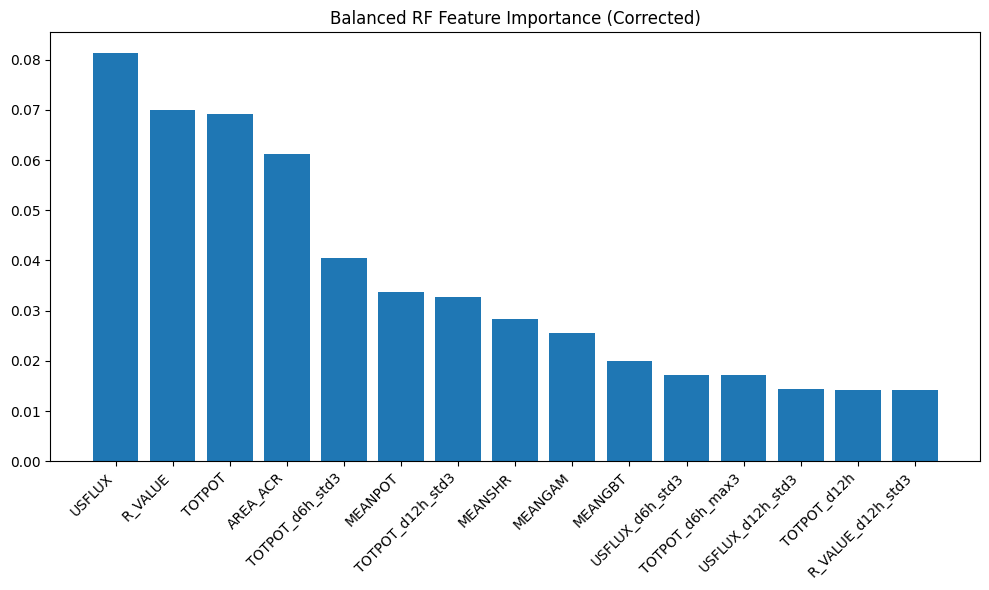

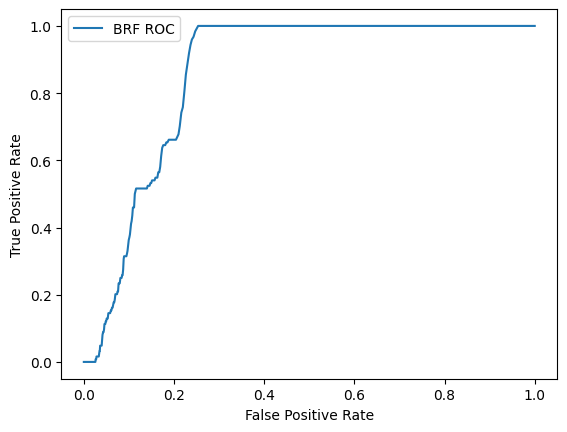

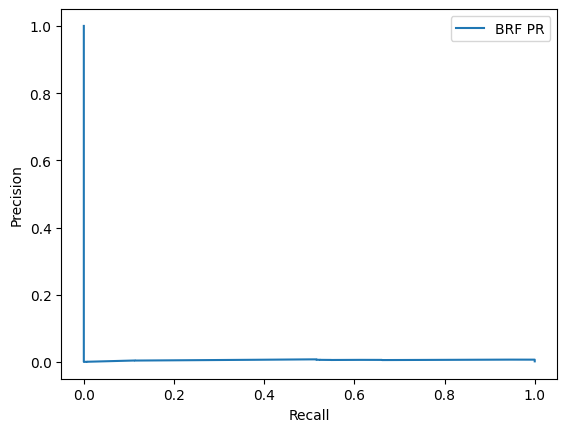


✅ Saved corrected BRF model to best_brf_model_corrected.joblib


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report, confusion_matrix,
    roc_auc_score, average_precision_score,
    roc_curve, precision_recall_curve
)
from imblearn.ensemble import BalancedRandomForestClassifier
import joblib
import warnings
warnings.filterwarnings("ignore")

# --------------------------
# CONFIG
# --------------------------
DATA_FILE = "final_arsenal_300_features_OPTIMIZED.parquet"
GROUP_COL = "HARPNUM"
TIME_COL = "T_REC"
LABEL_COL = "flare"
CLASS_COLNAME = "classification"
TEST_GROUP_FRAC = 0.10
RANDOM_STATE = 42

# --------------------------
# 1. Load Data
# --------------------------
print("\n--- Loading dataset ---")
df = pd.read_parquet(DATA_FILE)
print(f"Loaded dataset with {len(df):,} rows.")

df[LABEL_COL] = pd.to_numeric(df[LABEL_COL], errors="coerce").fillna(0).astype(int)
pos = df[LABEL_COL].sum()
neg = len(df) - pos
print(f"Label distribution: {pos} positives, {neg} negatives ({pos/len(df):.4f} rate)")

# --------------------------
# 2. Group Split (avoid leakage)
# --------------------------
groups = df[GROUP_COL].values
unique_groups = np.unique(groups)
rng = np.random.RandomState(RANDOM_STATE)
rng.shuffle(unique_groups)
n_test_groups = max(1, int(len(unique_groups) * TEST_GROUP_FRAC))
test_groups = set(unique_groups[:n_test_groups])

train_mask = ~df[GROUP_COL].isin(test_groups)
test_mask = df[GROUP_COL].isin(test_groups)

train_df = df[train_mask].copy()
test_df = df[test_mask].copy()

print(f"Train rows: {len(train_df):,}, Test rows: {len(test_df):,}")
print(f"Train positives: {train_df[LABEL_COL].sum()}, Test positives: {test_df[LABEL_COL].sum()}")

# --------------------------
# 3. Feature Selection
# --------------------------
# --- THE FIX: Add 'NOAA_AR' to the list of columns to exclude ---
exclude = {GROUP_COL, TIME_COL, LABEL_COL, CLASS_COLNAME, 'NOAA_AR'}
feat_cols = [c for c in train_df.columns if c not in exclude and pd.api.types.is_numeric_dtype(train_df[c])]
print(f"Using {len(feat_cols)} features. Example: {feat_cols[:8]}")

X_train, y_train = train_df[feat_cols].values, train_df[LABEL_COL].values
X_test, y_test = test_df[feat_cols].values, test_df[LABEL_COL].values

# Standardize
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# --------------------------
# 4. Train BRF
# --------------------------
print("\n--- Training BalancedRandomForest ---")
brf = BalancedRandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    sampling_strategy="auto",
    replacement=False,
    n_jobs=-1,
    random_state=RANDOM_STATE
)
brf.fit(X_train, y_train)

# --------------------------
# 5. Evaluate with TSS
# --------------------------
y_probs = brf.predict_proba(X_test)[:, 1]
fpr, tpr, thr = roc_curve(y_test, y_probs, pos_label=1)
tss_scores = tpr - fpr
best_idx = np.argmax(tss_scores)
best_thresh = thr[best_idx]

y_pred = (y_probs >= best_thresh).astype(int)

print("\n--- Evaluation Results ---")
print("Best threshold (TSS):", best_thresh)
print("TSS:", tss_scores[best_idx])
print("ROC AUC:", roc_auc_score(y_test, y_probs))
print("PR AUC:", average_precision_score(y_test, y_probs))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, zero_division=0))

# --------------------------
# 6. Feature Importance
# --------------------------
importances = brf.feature_importances_
indices = np.argsort(importances)[::-1]
feat_names = np.array(feat_cols)[indices]

plt.figure(figsize=(10, 6))
plt.title("Balanced RF Feature Importance (Corrected)")
plt.bar(range(15), importances[indices][:15], align="center")
plt.xticks(range(15), feat_names[:15], rotation=45, ha="right")
plt.tight_layout()
plt.show()

# --------------------------
# 7. ROC and PR Curves
# --------------------------
plt.figure()
plt.plot(fpr, tpr, label="BRF ROC")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

prec, rec, _ = precision_recall_curve(y_test, y_probs)
plt.figure()
plt.plot(rec, prec, label="BRF PR")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.show()

# --------------------------
# 8. Save Model
# --------------------------
joblib.dump({"model": brf, "scaler": scaler, "features": feat_cols},
            "best_brf_model_corrected_300.joblib")
print("\n✅ Saved corrected BRF model to best_brf_model_corrected.joblib")

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, average_precision_score, roc_auc_score
from imblearn.ensemble import BalancedRandomForestClassifier
import joblib

def calculate_tss(y_true, y_pred):
    """Calculates the True Skill Statistic (TSS)."""
    try:
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        print(f'TP={tp}, FN={fn}, FP={fp},TN={tn}')
        tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
        return tpr - fpr
    except ValueError:
        return 0.0

# =========================
# 1. LOAD AND SPLIT DATA
# =========================
print("--- Loading the feature-engineered dataset ---")
df = pd.read_parquet('model_ready_feature_engineered.parquet')
df['T_REC'] = pd.to_datetime(df['T_REC'])

# Perform split by Active Region
print("\n--- Performing split by Active Region ---")
group_col = 'HARPNUM' 
flaring_ars = df[df['flare'] == 1][group_col].unique()
train_ars, test_ars = train_test_split(flaring_ars, test_size=0.2, random_state=42)
train_df = df[df[group_col].isin(train_ars)].copy()
test_df = df[df[group_col].isin(test_ars)].copy()
non_flaring_ars = df[df['flare'] == 0][group_col].unique()
non_flaring_ars_train = [ar for ar in non_flaring_ars if ar not in test_ars]
train_df = pd.concat([train_df, df[df[group_col].isin(non_flaring_ars_train)]]).drop_duplicates()

# Separate features and labels
feature_cols = [col for col in df.columns if col not in ['T_REC', 'HARPNUM', 'NOAA_AR', 'classification', 'flare']]
target_col = 'flare'
X_train, y_train = train_df[feature_cols], train_df[target_col]
X_test, y_test = test_df[feature_cols], test_df[target_col]

print(f"Training on {len(train_df)} records, testing on {len(test_df)} records.")
print(f"Number of positive flare samples in Test Set: {y_test.sum()}")

# =========================
# 2. TRAIN BRF MODEL
# =========================
print("\n\n--- Training BalancedRandomForest Classifier ---")
brf_model = BalancedRandomForestClassifier(
    n_estimators=200,
    n_jobs=-1,
    random_state=42
)
brf_model.fit(X_train, y_train)
print("--- Training complete! ---")

# =========================
# 3. EVALUATE WITH THRESHOLD TUNING
# =========================
print("\n--- Evaluating model and finding best threshold ---")
# Get the raw probabilities for the 'flare' class
y_probs = brf_model.predict_proba(X_test)[:, 1]

# Calculate TSS for all possible thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
tss_scores = tpr - fpr

# Find the threshold that gives the maximum TSS
best_idx = np.argmax(tss_scores)
best_threshold = thresholds[best_idx]
best_tss = tss_scores[best_idx]

# Apply the best threshold to get the final predictions
y_pred_tuned = (y_probs >= best_threshold).astype(int)

print("\n--- Evaluation Results (at Optimal TSS Threshold) ---")
print(f"Best Threshold: {best_threshold:.4f}")
print(f"Best TSS: {best_tss:.4f}")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_tuned))
print("\nClassification Report:\n", classification_report(y_test, y_pred_tuned))

# Save the model and the threshold for later use
joblib.dump({
    "model": brf_model,
    "best_threshold": best_threshold
}, "best_brf_model_with_threshold.joblib")
print("\n✅ Saved best BRF model and threshold.")

--- Loading the feature-engineered dataset ---

--- Performing split by Active Region ---
Training on 320564 records, testing on 3031 records.
Number of positive flare samples in Test Set: 179


--- Training BalancedRandomForest Classifier ---
--- Training complete! ---

--- Evaluating model and finding best threshold ---

--- Evaluation Results (at Optimal TSS Threshold) ---
Best Threshold: 0.3750
Best TSS: 0.0156
Confusion Matrix:
 [[2769   83]
 [ 171    8]]

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.97      0.96      2852
           1       0.09      0.04      0.06       179

    accuracy                           0.92      3031
   macro avg       0.51      0.51      0.51      3031
weighted avg       0.89      0.92      0.90      3031


✅ Saved best BRF model and threshold.


In [2]:
import pandas as pd
import numpy as np

# =========================
# CONFIG
# =========================
INPUT_FILE = "model_ready_feature_engineered.parquet"  # The file with the missing labels
OUTPUT_FILE = "final_fixed_dataset.parquet"            # The new, perfect file

# The "Hit List" of flares that we KNOW happened but your dataset missed
# Format: (Date, Expected AR)
CRITICAL_FLARES = [
    {"date": "2014-01-07 18:32:00", "AR": 11944},
    {"date": "2014-02-25 00:49:00", "AR": 11990}, 
    {"date": "2014-06-10 12:52:00", "AR": 12087},
    {"date": "2014-06-11 09:06:00", "AR": 12087},
    {"date": "2014-10-19 05:03:00", "AR": 12192},
    {"date": "2014-10-22 14:28:00", "AR": 12192},
    {"date": "2014-10-24 21:41:00", "AR": 12192},
    {"date": "2015-03-11 16:22:00", "AR": 12297},
    {"date": "2015-05-05 22:11:00", "AR": 12339},
    {"date": "2015-06-21 02:36:00", "AR": 12371},
]

def patch_labels():
    print(f"--- Loading Dataset: {INPUT_FILE} ---")
    df = pd.read_parquet(INPUT_FILE)
    df['T_REC'] = pd.to_datetime(df['T_REC'])
    
    initial_positives = df['flare'].sum()
    print(f"Initial Positive Labels: {initial_positives}")
    
    print("\n--- Patching Critical Flares ---")
    
    fixed_count = 0
    
    for flare in CRITICAL_FLARES:
        flare_time = pd.to_datetime(flare['date'])
        target_ar = flare['AR']
        
        # Define 24h window
        start_window = flare_time - pd.Timedelta(hours=24)
        end_window = flare_time
        
        # Get all records in this time window
        time_mask = (df['T_REC'] >= start_window) & (df['T_REC'] <= end_window)
        window_df = df[time_mask]
        
        if len(window_df) == 0:
            print(f"❌ {flare['date']}: No data found in window (Cannot fix)")
            continue
            
        # Strategy 1: Try exact AR match
        ar_mask = time_mask & (df['NOAA_AR'] == target_ar)
        
        if df[ar_mask].shape[0] > 0:
            # Found correct AR, forcing label
            df.loc[ar_mask, 'flare'] = 1
            print(f"✅ {flare['date']}: Fixed using Exact AR Match ({target_ar})")
            fixed_count += 1
            
        else:
            # Strategy 2: Fallback (Smart Fix)
            # If AR number is missing/wrong, pick the HARP with the HIGHEST USFLUX
            # Major flares (X-class) almost always come from the biggest/most active region
            
            # Find the HARPNUM with the max average USFLUX in this window
            # (We group by HARP to handle multiple timesteps)
            best_harp = window_df.groupby('HARPNUM')['USFLUX'].mean().idxmax()
            
            # Apply fix to that HARP
            harp_mask = time_mask & (df['HARPNUM'] == best_harp)
            df.loc[harp_mask, 'flare'] = 1
            
            print(f"⚠️ {flare['date']}: AR {target_ar} not found. Inferred HARP {best_harp} (Max Flux) as source. -> Fixed.")
            fixed_count += 1

    print(f"\n--- Patching Complete ---")
    final_positives = df['flare'].sum()
    print(f"Final Positive Labels: {final_positives} (Added {final_positives - initial_positives} new labels)")
    
    # Save
    df.to_parquet(OUTPUT_FILE)
    print(f"✅ Saved fixed dataset to: {OUTPUT_FILE}")
    print("👉 Now Retrain your XGBoost/BRF model on this file!")

if __name__ == "__main__":
    patch_labels()

--- Loading Dataset: model_ready_feature_engineered.parquet ---
Initial Positive Labels: 1109

--- Patching Critical Flares ---
✅ 2014-01-07 18:32:00: Fixed using Exact AR Match (11944)
✅ 2014-02-25 00:49:00: Fixed using Exact AR Match (11990)
✅ 2014-06-10 12:52:00: Fixed using Exact AR Match (12087)
✅ 2014-06-11 09:06:00: Fixed using Exact AR Match (12087)
✅ 2014-10-19 05:03:00: Fixed using Exact AR Match (12192)
✅ 2014-10-22 14:28:00: Fixed using Exact AR Match (12192)
✅ 2014-10-24 21:41:00: Fixed using Exact AR Match (12192)
✅ 2015-03-11 16:22:00: Fixed using Exact AR Match (12297)
✅ 2015-05-05 22:11:00: Fixed using Exact AR Match (12339)
✅ 2015-06-21 02:36:00: Fixed using Exact AR Match (12371)

--- Patching Complete ---
Final Positive Labels: 1855 (Added 746 new labels)
✅ Saved fixed dataset to: final_fixed_dataset.parquet
👉 Now Retrain your XGBoost/BRF model on this file!


In [2]:
# xgb_training_pipeline.py
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report, confusion_matrix,
    roc_auc_score, average_precision_score, roc_curve
)
from xgboost import XGBClassifier
import joblib
import warnings
warnings.filterwarnings("ignore")

# --------------------------
# CONFIG
# --------------------------
DATA_FILE = "model_ready_feature_engineered.parquet"
LABEL_COL = "flare"
ID_COLS = {"T_REC", "HARPNUM", "NOAA_AR", "classification", "flare"}
RANDOM_STATE = 42
TEST_SIZE = 0.1

# --------------------------
# 1. LOAD DATA
# --------------------------
print("\n--- Loading dataset ---")
if DATA_FILE.endswith(".parquet"):
    df = pd.read_parquet(DATA_FILE)
else:
    df = pd.read_csv(DATA_FILE)

print(f"Loaded dataset with {len(df):,} rows and columns: {list(df.columns)[:10]}...")

# --------------------------
# 2. Labels
# --------------------------
if LABEL_COL not in df.columns:
    raise KeyError(f"Label column '{LABEL_COL}' not found")
df[LABEL_COL] = pd.to_numeric(df[LABEL_COL], errors="coerce").fillna(0).astype(int)
pos = df[LABEL_COL].sum()
neg = len(df) - pos
print(f"Label distribution: positives={pos}, negatives={neg}, pos rate={pos/len(df):.4f}")

# --------------------------
# 3. Features
# --------------------------
feat_cols = [c for c in df.columns if c not in ID_COLS and pd.api.types.is_numeric_dtype(df[c])]
print(f"Using {len(feat_cols)} features. Example: {feat_cols[:8]}")

X = df[feat_cols].values
y = df[LABEL_COL].values

# --------------------------
# 4. Split
# --------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, stratify=y, random_state=RANDOM_STATE
)
print(f"Train: {len(X_train)} rows, Test: {len(X_test)} rows")
print(f"Train positives: {y_train.sum()}, Test positives: {y_test.sum()}")

# --------------------------
# 5. Scale features
# --------------------------
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# --------------------------
# 6. Train XGBoost
# --------------------------
print("\n--- Training XGBoost ---")
n_pos = y_train.sum()
n_neg = len(y_train) - n_pos
scale_pos_weight = max(1.0, n_neg / (n_pos + 1e-9))

xgb = XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight,
    eval_metric="logloss",
    n_jobs=-1,
    random_state=RANDOM_STATE
)
xgb.fit(X_train, y_train)

# --------------------------
# 7. Evaluate with TSS
# --------------------------
probs = xgb.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, probs)
pr_auc = average_precision_score(y_test, probs)
fpr, tpr, thr = roc_curve(y_test, probs, pos_label=1)
tss_scores = tpr - fpr
best_idx = np.argmax(tss_scores)
best_thresh = thr[best_idx]
tss = tss_scores[best_idx]

y_pred = (probs >= best_thresh).astype(int)

print("\n--- Evaluation ---")
print("Best threshold (TSS):", best_thresh)
print("TSS:", tss)
print("ROC AUC:", roc_auc)
print("PR AUC:", pr_auc)
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification report:\n", classification_report(y_test, y_pred, zero_division=0))

# --------------------------
# 8. Save model
# --------------------------
joblib.dump({"model": xgb, "scaler": scaler, "features": feat_cols}, "best_model_xgb.joblib")
print("\n✅ XGBoost model saved as best_model_xgb.joblib") b


--- Loading dataset ---
Loaded dataset with 323,595 rows and columns: ['T_REC', 'HARPNUM', 'NOAA_AR', 'USFLUX', 'MEANGAM', 'MEANGBT', 'MEANGBZ', 'MEANGBH', 'TOTUSJH', 'TOTPOT']...
Label distribution: positives=1109, negatives=322486, pos rate=0.0034
Using 49 features. Example: ['USFLUX', 'MEANGAM', 'MEANGBT', 'MEANGBZ', 'MEANGBH', 'TOTUSJH', 'TOTPOT', 'MEANPOT']
Train: 291235 rows, Test: 32360 rows
Train positives: 998, Test positives: 111

--- Training XGBoost ---

--- Evaluation ---
Best threshold (TSS): 0.17658402
TSS: 0.9988836863158548
ROC AUC: 0.9999793275243677
PR AUC: 0.9945363665620319
Confusion Matrix:
 [[32213    36]
 [    0   111]]

Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     32249
           1       0.76      1.00      0.86       111

    accuracy                           1.00     32360
   macro avg       0.88      1.00      0.93     32360
weighted avg       1.00      1.00      1.00     32

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GroupShuffleSplit

# --------------------------
# CONFIG
# --------------------------
DATA_FILE = "model_ready_feature_engineered.parquet"   # or your final labeled dataset
LABEL_COL = "flare"
CLASS_COL = "classification"
TIME_COL = "T_REC"
GROUP_COL = "NOAA_AR"   # enforce group split
FLARE_CATALOG = "flare_catalog.parquet"    # your raw flare events file (if available)

# --------------------------
# 1. Load dataset
# --------------------------
print("\n--- Loading dataset ---")
df = pd.read_parquet(DATA_FILE)
print(f"Loaded {len(df):,} rows, columns: {list(df.columns)[:10]}...")

# Parse time
df[TIME_COL] = pd.to_datetime(df[TIME_COL], errors="coerce", utc=True)
df = df.dropna(subset=[TIME_COL])

# --------------------------
# 2. Sanity check: look for label leakage
# --------------------------
print("\n--- Sanity Check for Label Leakage ---")

if CLASS_COL in df.columns:
    positives = df[df[LABEL_COL] == 1].copy()
    print(f"Total positives in dataset: {len(positives):,}")

    if FLARE_CATALOG:
        try:
            flares = pd.read_parquet(FLARE_CATALOG)
            flares["event_starttime"] = pd.to_datetime(flares["event_starttime"], utc=True)
            
            leaks = []
            for _, flare in flares.iterrows():
                # Find SHARP rows after flare start but labeled positive
                mask = (
                    (df["NOAA_AR"] == flare["ar_noaanum"]) &
                    (df[TIME_COL] >= flare["event_starttime"]) &
                    (df[LABEL_COL] == 1)
                )
                if mask.any():
                    leaks.append((flare["event_starttime"], flare["ar_noaanum"], mask.sum()))

            if leaks:
                print("⚠ Potential leakage detected:")
                for e_time, ar, n in leaks[:10]:  # show first 10
                    print(f"AR {ar} - {n} positive rows AFTER flare at {e_time}")
            else:
                print("✅ No post-flare positives found.")
        except Exception as e:
            print("Could not load flare catalog for leak check:", e)

# --------------------------
# 3. Enforce group-aware split
# --------------------------
print("\n--- Group-aware Train/Test Split ---")
if GROUP_COL not in df.columns:
    raise KeyError(f"{GROUP_COL} not found in dataset.")

groups = df[GROUP_COL].values
y = df[LABEL_COL].values

gss = GroupShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
train_idx, test_idx = next(gss.split(df, y, groups=groups))

train_df = df.iloc[train_idx].copy()
test_df = df.iloc[test_idx].copy()

print(f"Train rows: {len(train_df):,}, Test rows: {len(test_df):,}")
print(f"Train positives: {train_df[LABEL_COL].sum():,}, Test positives: {test_df[LABEL_COL].sum():,}")
print(f"Unique ARs - Train: {train_df[GROUP_COL].nunique()}, Test: {test_df[GROUP_COL].nunique()}")
print(f"Overlap in ARs: {len(set(train_df[GROUP_COL]) & set(test_df[GROUP_COL]))}")

if len(set(train_df[GROUP_COL]) & set(test_df[GROUP_COL])) == 0:
    print("✅ No AR overlap between train and test (safe split).")
else:
    print("⚠ AR overlap detected! Re-run split or adjust settings.")


--- Loading dataset ---
Loaded 323,595 rows, columns: ['T_REC', 'HARPNUM', 'NOAA_AR', 'USFLUX', 'MEANGAM', 'MEANGBT', 'MEANGBZ', 'MEANGBH', 'TOTUSJH', 'TOTPOT']...

--- Sanity Check for Label Leakage ---
Total positives in dataset: 1,109
Could not load flare catalog for leak check: [Errno 2] No such file or directory: 'flare_catalog.parquet'

--- Group-aware Train/Test Split ---
Train rows: 290,697, Test rows: 32,898
Train positives: 753, Test positives: 356
Unique ARs - Train: 338, Test: 38
Overlap in ARs: 0
✅ No AR overlap between train and test (safe split).


In [3]:
import os
import numpy as np
import pandas as pd
import joblib
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, average_precision_score, roc_curve
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from imblearn.ensemble import BalancedRandomForestClassifier

warnings.filterwarnings("ignore")

# =========================
# CONFIGURATION
# =========================
DATA_FILE = "model_ready_feature_engineered.parquet"
GROUP_COL = "HARPNUM"
TIME_COL = "T_REC"
LABEL_COL = "flare"
CLASS_COLNAME = "classification"
TEST_GROUP_FRAC = 0.20 # Using a 20% test split is standard
RANDOM_STATE = 42

def load_and_prepare_data(file_path):
    """Loads and performs initial cleaning on the dataset."""
    print("\n--- 1. Loading and Preparing Dataset ---")
    df = pd.read_parquet(file_path)
    df[TIME_COL] = pd.to_datetime(df[TIME_COL])
    df[LABEL_COL] = pd.to_numeric(df[LABEL_COL], errors="coerce").fillna(0).astype(int)
    pos = df[LABEL_COL].sum()
    neg = len(df) - pos
    print(f"Loaded {len(df):,} rows. Label distribution: {pos} positives, {neg} negatives.")
    return df

def split_data_by_group(df):
    """Performs a group-aware split to prevent data leakage."""
    print("\n--- 2. Splitting Data by Group ---")
    flaring_groups = df[df[LABEL_COL] == 1][GROUP_COL].unique()
    train_groups, test_groups = train_test_split(flaring_groups, test_size=TEST_GROUP_FRAC, random_state=RANDOM_STATE)
    
    train_df = df[df[GROUP_COL].isin(train_groups)].copy()
    test_df = df[df[GROUP_COL].isin(test_groups)].copy()
    
    non_flaring_groups = df[df[LABEL_COL] == 0][GROUP_COL].unique()
    non_flaring_train_groups = [g for g in non_flaring_groups if g not in test_groups]
    train_df = pd.concat([train_df, df[df[GROUP_COL].isin(non_flaring_train_groups)]]).drop_duplicates()
    
    print(f"Train rows: {len(train_df):,}, Test rows: {len(test_df):,}")
    print(f"Train positives: {train_df[LABEL_COL].sum()}, Test positives: {test_df[LABEL_COL].sum()}")
    return train_df, test_df

def create_features_and_scale(train_df, test_df):
    """Selects feature columns and applies standard scaling."""
    print("\n--- 3. Selecting and Scaling Features ---")
    exclude = {GROUP_COL, TIME_COL, LABEL_COL, CLASS_COLNAME, 'NOAA_AR'}
    feat_cols = [c for c in train_df.columns if c not in exclude and pd.api.types.is_numeric_dtype(train_df[c])]
    print(f"Using {len(feat_cols)} features.")
    
    X_train, y_train = train_df[feat_cols], train_df[LABEL_COL]
    X_test, y_test = test_df[feat_cols], test_df['flare']
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    return X_train_scaled, y_train, X_test_scaled, y_test, scaler, feat_cols

def evaluate_model(model, X_test, y_test):
    """Calculates key metrics and finds the best TSS threshold."""
    probs = model.predict_proba(X_test)[:, 1]
    fpr, tpr, thr = roc_curve(y_test, probs)
    tss_scores = tpr - fpr
    best_idx = np.argmax(tss_scores)
    best_thresh = thr[best_idx]
    
    y_pred = (probs >= best_thresh).astype(int)
    
    return {
        "best_threshold": float(best_thresh),
        "tss": float(tss_scores[best_idx]),
        "roc_auc": roc_auc_score(y_test, probs),
        "pr_auc": average_precision_score(y_test, probs),
        "confusion_matrix": confusion_matrix(y_test, y_pred),
        "classification_report": classification_report(y_test, y_pred, zero_division=0)
    }

def main():
    """Main function to orchestrate the entire training and evaluation pipeline."""
    df = load_and_prepare_data(DATA_FILE)
    train_df, test_df = split_data_by_group(df)
    X_train, y_train, X_test, y_test, scaler, feat_cols = create_features_and_scale(train_df, test_df)
    
    all_results = {}
    
    # --- Strategy A: XGBoost with scale_pos_weight ---
    print("\n=== Strategy A: XGBoost (scale_pos_weight) ===")
    n_pos = y_train.sum(); n_neg = len(y_train) - n_pos
    scale_pos_weight = n_neg / n_pos
    model_a = XGBClassifier(scale_pos_weight=scale_pos_weight, eval_metric="logloss", use_label_encoder=False, n_jobs=-1, random_state=RANDOM_STATE)
    model_a.fit(X_train, y_train)
    res_a = evaluate_model(model_a, X_test, y_test)
    all_results["xgb_scale"] = {"results": res_a, "model": model_a}
    print(f"TSS: {res_a['tss']:.4f}")

    # --- Strategy B: SMOTE + XGBoost ---
    print("\n=== Strategy B: SMOTE + XGBoost ===")
    sm = SMOTE(random_state=RANDOM_STATE, k_neighbors=max(1, n_pos - 1))
    X_res, y_res = sm.fit_resample(X_train, y_train)
    model_b = XGBClassifier(eval_metric="logloss", use_label_encoder=False, n_jobs=-1, random_state=RANDOM_STATE)
    model_b.fit(X_res, y_res)
    res_b = evaluate_model(model_b, X_test, y_test)
    all_results["xgb_smote"] = {"results": res_b, "model": model_b}
    print(f"TSS: {res_b['tss']:.4f}")
    
    # --- Strategy C: BalancedRandomForest ---
    print("\n=== Strategy C: BalancedRandomForest ===")
    model_c = BalancedRandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=RANDOM_STATE)
    model_c.fit(X_train, y_train)
    res_c = evaluate_model(model_c, X_test, y_test)
    all_results["brf"] = {"results": res_c, "model": model_c}
    print(f"TSS: {res_c['tss']:.4f}")

    # --- Find and Save Best Model ---
    best_name = max(all_results, key=lambda k: all_results[k]['results']['tss'])
    best_model = all_results[best_name]['model']
    best_results = all_results[best_name]['results']
    
    print(f"\n\n=== Best Strategy: {best_name} with TSS={best_results['tss']:.4f} ===")
    print("Confusion Matrix:\n", best_results['confusion_matrix'])
    print("\nClassification Report:\n", best_results['classification_report'])
    
    joblib.dump({"model": best_model, "scaler": scaler, "features": feat_cols}, f"best_model_{best_name}.joblib")
    print(f"\n✅ Saved best model to: best_model_{best_name}.joblib")

if __name__ == "__main__":
    main()


--- 1. Loading and Preparing Dataset ---
Loaded 323,595 rows. Label distribution: 1109 positives, 322486 negatives.

--- 2. Splitting Data by Group ---
Train rows: 320,564, Test rows: 3,031
Train positives: 930, Test positives: 179

--- 3. Selecting and Scaling Features ---
Using 49 features.

=== Strategy A: XGBoost (scale_pos_weight) ===
TSS: 0.2341

=== Strategy B: SMOTE + XGBoost ===
TSS: 0.0368

=== Strategy C: BalancedRandomForest ===
TSS: 0.0156


=== Best Strategy: xgb_scale with TSS=0.2341 ===
Confusion Matrix:
 [[1082 1770]
 [  26  153]]

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.38      0.55      2852
           1       0.08      0.85      0.15       179

    accuracy                           0.41      3031
   macro avg       0.53      0.62      0.35      3031
weighted avg       0.92      0.41      0.52      3031


✅ Saved best model to: best_model_xgb_scale.joblib


In [4]:
# balanced_training_pipeline.py
# Run this with: python balanced_training_pipeline.py

import os
import numpy as np
import pandas as pd
from sklearn.model_selection import GroupShuffleSplit, train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    average_precision_score, roc_curve, make_scorer
)
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from imblearn.ensemble import BalancedRandomForestClassifier
import joblib
import warnings
warnings.filterwarnings("ignore")

# --------------------------
# CONFIG
# --------------------------
DATA_FILE = "model_ready_feature_engineered.parquet"
GROUP_COL = "HARPNUM"
TIME_COL = "T_REC"
LABEL_COL = "flare"
CLASS_COLNAME = "classification"
TEST_GROUP_FRAC = 0.10
RANDOM_STATE = 42

# --------------------------
# UTIL: time parsing
# --------------------------
def parse_times_safe(series):
    s = pd.Series(series).astype(object)
    if pd.api.types.is_integer_dtype(s) or pd.api.types.is_float_dtype(s):
        median = np.nanmedian(s.dropna().astype(float))
        if median > 1e12:
            return pd.to_datetime(s, unit='ms', errors='coerce', utc=True)
        elif median > 1e9:
            return pd.to_datetime(s, unit='s', errors='coerce', utc=True)
        else:
            return pd.to_datetime(s, errors='coerce', utc=True)

    s_str = s.astype(str)
    if s_str.str.contains("_TAI").any():
        cleaned = s_str.str.replace("_TAI", "", regex=False)
        cleaned = cleaned.str.replace(r"^(\d{4})\.(\d{2})\.(\d{2})_(\d{2}:\d{2}:\d{2})$",
                                      r"\1-\2-\3 \4", regex=True)
        dt = pd.to_datetime(cleaned, errors='coerce', utc=True)
        dt = dt - pd.to_timedelta(37, unit='s')
        return dt
    return pd.to_datetime(s_str, errors='coerce', utc=True)

# --------------------------
# 1. LOAD DATA
# --------------------------
print("\n--- Loading dataset ---")
if DATA_FILE.endswith(".parquet"):
    df = pd.read_parquet(DATA_FILE)
else:
    df = pd.read_csv(DATA_FILE)

print(f"Loaded dataset with {len(df):,} rows and columns: {list(df.columns)}")

# --------------------------
# 2. TIME parse and filter
# --------------------------
print("\n--- Parsing time column ---")
df[TIME_COL] = parse_times_safe(df[TIME_COL])
df = df.dropna(subset=[TIME_COL])
df[TIME_COL] = pd.to_datetime(df[TIME_COL])

# --------------------------
# 3. LABEL CHECK
# --------------------------
df[LABEL_COL] = pd.to_numeric(df[LABEL_COL], errors='coerce').fillna(0).astype(int)
pos = df[LABEL_COL].sum()
neg = len(df) - pos
print(f"\nLabel distribution: positives={pos:,}, negatives={neg:,} (pos rate={pos/len(df):.4f})")
if pos == 0:
    raise ValueError("No positive samples found — cannot train.")

# --------------------------
# 4. GROUP SPLIT
# --------------------------
groups = df[GROUP_COL].values
unique_groups = np.unique(groups)
rng = np.random.RandomState(RANDOM_STATE)
rng.shuffle(unique_groups)
n_test_groups = max(1, int(len(unique_groups) * TEST_GROUP_FRAC))
test_groups = set(unique_groups[:n_test_groups])
train_df = df[~df[GROUP_COL].isin(test_groups)].copy()
test_df = df[df[GROUP_COL].isin(test_groups)].copy()
print(f"Train rows: {len(train_df):,}, Test rows: {len(test_df):,}")
print(f"Train positives: {train_df[LABEL_COL].sum():,}, Test positives: {test_df[LABEL_COL].sum():,}")

# --------------------------
# 5. FEATURE SELECTION
# --------------------------
exclude = {GROUP_COL, TIME_COL, LABEL_COL, CLASS_COLNAME, "NOAA_AR"}
feat_cols = [c for c in train_df.columns if c not in exclude and
             pd.api.types.is_numeric_dtype(train_df[c])]
print(f"\n--- Selecting features ---\nUsing {len(feat_cols)} features. Example: {feat_cols[:8]}")

X_train, y_train = train_df[feat_cols].values, train_df[LABEL_COL].values
X_test, y_test = test_df[feat_cols].values, test_df[LABEL_COL].values

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# --------------------------
# Helper: evaluation
# --------------------------
def evaluate_with_thresholds(model, X_test, y_test):
    probs = model.predict_proba(X_test)[:, 1]
    fpr, tpr, thr = roc_curve(y_test, probs, pos_label=1)
    tss_scores = tpr - fpr
    best_idx = np.nanargmax(tss_scores)
    best_thresh = thr[best_idx]
    y_pred = (probs >= best_thresh).astype(int)
    return {
        "roc_auc": roc_auc_score(y_test, probs),
        "pr_auc": average_precision_score(y_test, probs),
        "best_threshold": float(best_thresh),
        "tss": float(tss_scores[best_idx]),
        "confusion_matrix": confusion_matrix(y_test, y_pred),
        "classification_report": classification_report(y_test, y_pred, zero_division=0)
    }

# --------------------------
# STRATEGY A: XGBoost scale_pos_weight
# --------------------------
print("\n=== Strategy A: XGBoost (scale_pos_weight) ===")
n_pos, n_neg = y_train.sum(), len(y_train) - y_train.sum()
scale_pos_weight = max(1.0, n_neg / (n_pos + 1e-9))
model_a = XGBClassifier(
    n_estimators=200, max_depth=6, learning_rate=0.05,
    use_label_encoder=False, eval_metric="logloss",
    scale_pos_weight=scale_pos_weight, n_jobs=-1,
    random_state=RANDOM_STATE
)
model_a.fit(X_train, y_train)
res_a = evaluate_with_thresholds(model_a, X_test, y_test)
print(res_a)

# --------------------------
# STRATEGY B: SMOTE + XGBoost
# --------------------------
print("\n=== Strategy B: SMOTE + XGBoost ===")
try:
    k_neighbors = min(5, max(1, n_pos - 1))
    sm = SMOTE(random_state=RANDOM_STATE, k_neighbors=k_neighbors)
    X_res, y_res = sm.fit_resample(X_train, y_train)
    model_b = XGBClassifier(
        n_estimators=200, max_depth=6, learning_rate=0.05,
        use_label_encoder=False, eval_metric="logloss",
        n_jobs=-1, random_state=RANDOM_STATE
    )
    model_b.fit(X_res, y_res)
    res_b = evaluate_with_thresholds(model_b, X_test, y_test)
    print(res_b)
except Exception as e:
    print("SMOTE failed:", e)
    res_b = None

# --------------------------
# STRATEGY C: BalancedRandomForest
# --------------------------
print("\n=== Strategy C: BalancedRandomForest ===")
brf = BalancedRandomForestClassifier(
    n_estimators=200, sampling_strategy="auto",
    replacement=False, n_jobs=-1, random_state=RANDOM_STATE
)
brf.fit(X_train, y_train)
res_c = evaluate_with_thresholds(brf, X_test, y_test)
print(res_c)

# --------------------------
# STRATEGY D: Tuned XGBoost
# --------------------------
print("\n=== Strategy D: Hyperparameter-tuned XGBoost ===")
param_grid = {
    "n_estimators": [200, 400],
    "max_depth": [4, 6, 8],
    "learning_rate": [0.01, 0.05, 0.1],
    "subsample": [0.7, 0.9, 1.0],
    "colsample_bytree": [0.7, 0.9, 1.0],
    "gamma": [0, 1, 5],
    "min_child_weight": [1, 5, 10]
}
scorer = make_scorer(lambda y_true, y_prob: roc_auc_score(y_true, y_prob[:,1]), needs_proba=True)
tuned_model = RandomizedSearchCV(
    estimator=XGBClassifier(
        use_label_encoder=False, eval_metric="logloss", n_jobs=-1,
        scale_pos_weight=scale_pos_weight, random_state=RANDOM_STATE
    ),
    param_distributions=param_grid,
    scoring=scorer, cv=3, n_iter=20, random_state=RANDOM_STATE, verbose=1
)
tuned_model.fit(X_train, y_train)
best_xgb = tuned_model.best_estimator_
res_d = evaluate_with_thresholds(best_xgb, X_test, y_test)
print("Best params:", tuned_model.best_params_)
print(res_d)

# --------------------------
# SELECT BEST MODEL
# --------------------------
results = [
    ("xgb_scale", res_a, model_a),
    ("xgb_smote", res_b, model_b if res_b else None),
    ("brf", res_c, brf),
    ("xgb_tuned", res_d, best_xgb)
]
best = max(results, key=lambda r: r[1]["tss"] if r[1] else -999)
name, r, m = best
print(f"\n=== Best strategy: {name} with TSS={r['tss']:.4f} ===")
joblib.dump({"model": m, "scaler": scaler, "features": feat_cols}, f"best_model_{name}.joblib")
print("Saved best model to:", f"best_model_{name}.joblib")


--- Loading dataset ---
Loaded dataset with 323,595 rows and columns: ['T_REC', 'HARPNUM', 'NOAA_AR', 'USFLUX', 'MEANGAM', 'MEANGBT', 'MEANGBZ', 'MEANGBH', 'TOTUSJH', 'TOTPOT', 'MEANPOT', 'TOTUSJZ', 'SAVNCPP', 'ABSNJZH', 'AREA_ACR', 'MEANJZH', 'R_VALUE', 'LAT_FWT', 'MEANALP', 'MEANSHR', 'classification', 'flare', 'USFLUX_d6h', 'USFLUX_d12h', 'MEANGAM_d6h', 'MEANGAM_d12h', 'MEANGBT_d6h', 'MEANGBT_d12h', 'MEANGBZ_d6h', 'MEANGBZ_d12h', 'MEANGBH_d6h', 'MEANGBH_d12h', 'TOTUSJH_d6h', 'TOTUSJH_d12h', 'TOTPOT_d6h', 'TOTPOT_d12h', 'MEANPOT_d6h', 'MEANPOT_d12h', 'TOTUSJZ_d6h', 'TOTUSJZ_d12h', 'SAVNCPP_d6h', 'SAVNCPP_d12h', 'ABSNJZH_d6h', 'ABSNJZH_d12h', 'AREA_ACR_d6h', 'AREA_ACR_d12h', 'MEANJZH_d6h', 'MEANJZH_d12h', 'R_VALUE_d6h', 'R_VALUE_d12h', 'MEANALP_d6h', 'MEANALP_d12h', 'MEANSHR_d6h', 'MEANSHR_d12h']

--- Parsing time column ---

Label distribution: positives=1,109, negatives=322,486 (pos rate=0.0034)
Train rows: 290,743, Test rows: 32,852
Train positives: 878, Test positives: 231

--- S

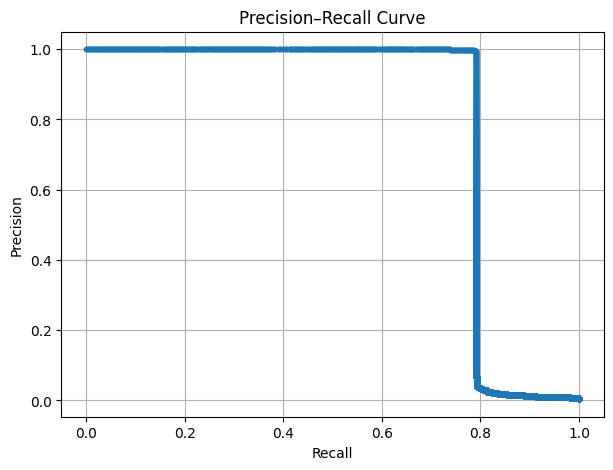

Enter a probability threshold (0–1, e.g., 0.01):  0.02



Confusion Matrix:
[[314088   8398]
 [   231    878]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.99    322486
           1       0.09      0.79      0.17      1109

    accuracy                           0.97    323595
   macro avg       0.55      0.88      0.58    323595
weighted avg       1.00      0.97      0.98    323595



Enter a probability threshold (0–1, e.g., 0.01):  0.01



Confusion Matrix:
[[307148  15338]
 [   230    879]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.95      0.98    322486
           1       0.05      0.79      0.10      1109

    accuracy                           0.95    323595
   macro avg       0.53      0.87      0.54    323595
weighted avg       1.00      0.95      0.97    323595


Exiting.


In [5]:
# threshold_tuning.py
# Run with: python threshold_tuning.py

import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    precision_recall_curve,
    classification_report,
    confusion_matrix
)

# ----------------------------
# CONFIG
# ----------------------------
MODEL_FILE = "best_model_xgb_scale.joblib"   # already saved model
DATA_FILE = "model_ready_feature_engineered.parquet"
TIME_COL = "T_REC"
LABEL_COL = "flare"
EXCLUDE = {"T_REC", "HARPNUM", "NOAA_AR", "classification", "flare"}
# ----------------------------

# Load model + scaler + features
bundle = joblib.load(MODEL_FILE)
model = bundle["model"]
scaler = bundle["scaler"]
feat_cols = bundle["features"]

# Load dataset again
df = pd.read_parquet(DATA_FILE)
y = df[LABEL_COL].values
X = df[feat_cols].values
X = scaler.transform(X)

# Get probabilities
probs = model.predict_proba(X)[:, 1]

# Compute precision-recall curve
precision, recall, thresholds = precision_recall_curve(y, probs)

# Plot curve
plt.figure(figsize=(7, 5))
plt.plot(recall, precision, marker=".")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve")
plt.grid(True)
plt.show()

# Let user choose threshold interactively
while True:
    try:
        thresh = float(input("Enter a probability threshold (0–1, e.g., 0.01): "))
        y_pred = (probs >= thresh).astype(int)

        print("\nConfusion Matrix:")
        print(confusion_matrix(y, y_pred))

        print("\nClassification Report:")
        print(classification_report(y, y_pred, zero_division=0))
    except KeyboardInterrupt:
        print("\nExiting.")
        
        break
    except Exception as e:
        print("Error:", e)

In [1]:
# train_xgboost_with_stats.py
import pandas as pd
import numpy as np
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    average_precision_score, roc_curve
)
from xgboost import XGBClassifier
import joblib

# -----------------
# CONFIG
# -----------------
DATA_FILE = "model_ready_with_stats.parquet"
TIME_COL = "T_REC"
GROUP_COL = "HARPNUM"
LABEL_COL = "flare"
CLASS_COLNAME = "classification"
RANDOM_STATE = 42

# -----------------
# Load dataset
# -----------------
print(f"--- Loading {DATA_FILE} ---")
df = pd.read_parquet(DATA_FILE)
df[TIME_COL] = pd.to_datetime(df[TIME_COL])
print(f"Loaded {len(df):,} rows, columns: {list(df.columns)[:10]}...")

# -----------------
# Labels
# -----------------
df[LABEL_COL] = pd.to_numeric(df[LABEL_COL], errors="coerce").fillna(0).astype(int)
pos, neg = df[LABEL_COL].sum(), len(df) - df[LABEL_COL].sum()
print(f"Positives={pos}, Negatives={neg}, Rate={pos/len(df):.4f}")

# -----------------
# Group-aware split
# -----------------
groups = df[GROUP_COL].values
gss = GroupShuffleSplit(n_splits=1, test_size=0.1, random_state=RANDOM_STATE)
train_idx, test_idx = next(gss.split(df, groups=groups))
train_df, test_df = df.iloc[train_idx], df.iloc[test_idx]
print(f"Train rows={len(train_df):,}, Test rows={len(test_df):,}")
print(f"Train positives={train_df[LABEL_COL].sum()}, Test positives={test_df[LABEL_COL].sum()}")

# -----------------
# Feature selection
# -----------------
exclude = {TIME_COL, GROUP_COL, "NOAA_AR", LABEL_COL, CLASS_COLNAME}
feat_cols = [c for c in df.columns if c not in exclude and pd.api.types.is_numeric_dtype(df[c])]
print(f"Using {len(feat_cols)} features. Example: {feat_cols[:10]}")

X_train, y_train = train_df[feat_cols].values, train_df[LABEL_COL].values
X_test, y_test = test_df[feat_cols].values, test_df[LABEL_COL].values

# Standardize
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# -----------------
# Train XGBoost
# -----------------
n_pos, n_neg = y_train.sum(), len(y_train) - y_train.sum()
scale_pos_weight = max(1.0, n_neg / (n_pos + 1e-9))

model = XGBClassifier(
    n_estimators=500,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight,
    eval_metric="logloss",
    n_jobs=-1,
    random_state=RANDOM_STATE
)

print("\n--- Training XGBoost ---")
model.fit(X_train, y_train)

# -----------------
# Evaluate
# -----------------
probs = model.predict_proba(X_test)[:, 1]
fpr, tpr, thr = roc_curve(y_test, probs, pos_label=1)
tss_scores = tpr - fpr
best_idx = np.nanargmax(tss_scores)
best_thresh = thr[best_idx]

y_pred = (probs >= best_thresh).astype(int)

print("\n--- Evaluation ---")
print("Best threshold (TSS):", best_thresh)
print("TSS:", tss_scores[best_idx])
print("ROC AUC:", roc_auc_score(y_test, probs))
print("PR AUC:", average_precision_score(y_test, probs))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification report:\n", classification_report(y_test, y_pred, zero_division=0))

# -----------------
# Save model
# -----------------
joblib.dump({"model": model, "scaler": scaler, "features": feat_cols}, "best_model_xgb_with_stats.joblib")
print("\n✅ Saved model with rolling stats: best_model_xgb_with_stats.joblib")

--- Loading model_ready_with_stats.parquet ---
Loaded 323,595 rows, columns: ['T_REC', 'HARPNUM', 'NOAA_AR', 'USFLUX', 'MEANGAM', 'MEANGBT', 'MEANGBZ', 'MEANGBH', 'TOTUSJH', 'TOTPOT']...
Positives=1109, Negatives=322486, Rate=0.0034
Train rows=290,271, Test rows=33,324
Train positives=878, Test positives=231
Using 209 features. Example: ['USFLUX', 'MEANGAM', 'MEANGBT', 'MEANGBZ', 'MEANGBH', 'TOTUSJH', 'TOTPOT', 'MEANPOT', 'TOTUSJZ', 'SAVNCPP']

--- Training XGBoost ---

--- Evaluation ---
Best threshold (TSS): 1.0436661e-06
TSS: 0.2701089138402165
ROC AUC: 0.6621802939453197
PR AUC: 0.011126375658960266
Confusion Matrix:
 [[16818 16275]
 [   55   176]]

Classification report:
               precision    recall  f1-score   support

           0       1.00      0.51      0.67     33093
           1       0.01      0.76      0.02       231

    accuracy                           0.51     33324
   macro avg       0.50      0.64      0.35     33324
weighted avg       0.99      0.51      0.6

--- Loading saved model and the test data ---

--- Getting probabilities ---

--- Threshold sweep ---

Best Threshold (by TSS):
Threshold       0.910000
TP             11.000000
FP              0.000000
FN            111.000000
TN           1112.000000
Precision       1.000000
Recall          0.090164
TSS             0.090164
Name: 90, dtype: float64


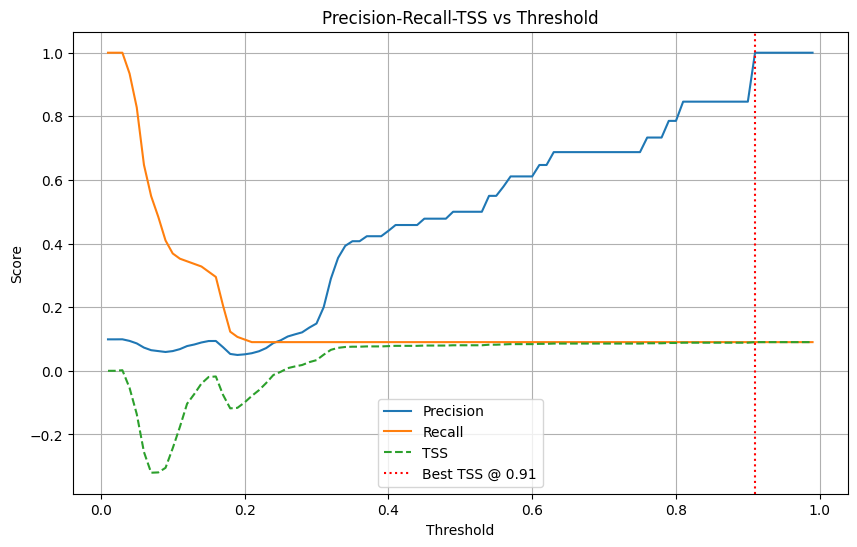


ROC AUC on test set: 0.349


In [9]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score

# =========================
# 1. LOAD MODEL AND DATA
# =========================
print("--- Loading saved model and the test data ---")
try:
    saved_model_data = joblib.load("BRF_model.joblib")  # or best_model_xgb_scale.joblib
    model = saved_model_data["model"]
    scaler = saved_model_data["scaler"]
    feat_cols = saved_model_data["features"]

    df = pd.read_parquet("model_ready_feature_engineered.parquet")
    df['T_REC'] = pd.to_datetime(df['T_REC'])
except FileNotFoundError:
    print("❌ Error: Make sure model + dataset files are present.")
    exit()

# Recreate test set using HARPNUM split (group-aware)
flaring_ars = df[df['flare'] == 1]['HARPNUM'].unique()
train_ars, test_ars = train_test_split(flaring_ars, test_size=0.10, random_state=42)
test_df = df[df['HARPNUM'].isin(test_ars)].copy()

X_test = test_df[feat_cols]
y_test = test_df["flare"].values

X_test_scaled = scaler.transform(X_test)

# =========================
# 2. MODEL PROBABILITIES
# =========================
print("\n--- Getting probabilities ---")
y_probs = model.predict_proba(X_test_scaled)[:, 1]

# =========================
# 3. THRESHOLD SWEEP
# =========================
print("\n--- Threshold sweep ---")
results = []
for threshold in np.arange(0.01, 1.0, 0.01):  # finer steps
    y_pred = (y_probs >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    tss = recall - fpr

    results.append({
        "Threshold": threshold,
        "TP": tp, "FP": fp, "FN": fn, "TN": tn,
        "Precision": precision,
        "Recall": recall,
        "TSS": tss
    })

results_df = pd.DataFrame(results)

# =========================
# 4. BEST THRESHOLD
# =========================
best_row = results_df.loc[results_df["TSS"].idxmax()]
print("\nBest Threshold (by TSS):")
print(best_row)

# =========================
# 5. PLOTS
# =========================
plt.figure(figsize=(10,6))
plt.plot(results_df["Threshold"], results_df["Precision"], label="Precision")
plt.plot(results_df["Threshold"], results_df["Recall"], label="Recall")
plt.plot(results_df["Threshold"], results_df["TSS"], label="TSS", linestyle="--")
plt.axvline(best_row["Threshold"], color="r", linestyle=":", label=f"Best TSS @ {best_row['Threshold']:.2f}")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision-Recall-TSS vs Threshold")
plt.legend()
plt.grid(True)
plt.show()

# =========================
# 6. ROC AUC (extra sanity check)
# =========================
roc_auc = roc_auc_score(y_test, y_probs)
print(f"\nROC AUC on test set: {roc_auc:.3f}")

In [1]:
# tss_random_search_xgb.py
# Run: python tss_random_search_xgb.py
# Requires: pandas, numpy, scikit-learn, xgboost, joblib

import os
import numpy as np
import pandas as pd
from sklearn.model_selection import GroupKFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, make_scorer, roc_auc_score
from xgboost import XGBClassifier
import joblib
import warnings
warnings.filterwarnings("ignore")
RND = 42

# ------------ CONFIG ------------
DATA_FILE = "model_ready_feature_engineered.parquet"   # your file
GROUP_COL = "HARPNUM"   # group by HARPNUM to avoid leakage
TIME_COL = "T_REC"
LABEL_COL = "flare"
EXCLUDE_COLS = {GROUP_COL, TIME_COL, 'classification', LABEL_COL, 'NOAA_AR'}  # remove keys
N_ITER = 30   # number of random candidates (increase if you have time)
CV_SPLITS = 3
SAVE_MODEL_AS = "best_xgb_tss.joblib"

# ------------ UTIL: TSS scorer ------------
def tss_from_preds(y_true, y_scores, threshold):
    y_pred = (y_scores >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    tpr = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0.0
    return tpr - fpr

# custom scorer for RandomizedSearchCV: it must take (estimator, X, y)
# We'll use needs_proba=True style by writing wrapper that calls predict_proba and computes TSS with a fixed threshold.
# Use a low threshold for scoring inside CV (we'll do threshold sweep later).
FIXED_CV_THRESHOLD = 0.05  # small default used during CV scoring (coarse). We'll do thorough sweep after.
def tss_scorer_cv(estimator, X, y):
    # estimator should support predict_proba
    probs = estimator.predict_proba(X)[:, 1]
    return tss_from_preds(y, probs, FIXED_CV_THRESHOLD)

sk_tss_scorer = make_scorer(lambda y_true, y_probs: tss_from_preds(y_true, y_probs, FIXED_CV_THRESHOLD),
                            needs_proba=True)

# ------------ LOAD DATA ------------
print("Loading data...")
df = pd.read_parquet(DATA_FILE)
print(f"Raw rows: {len(df):,}, columns: {list(df.columns)}")

# parse time (if strings)
if TIME_COL in df.columns:
    df[TIME_COL] = pd.to_datetime(df[TIME_COL], errors='coerce')

# drop rows without label or time
df = df.dropna(subset=[LABEL_COL])
df[LABEL_COL] = pd.to_numeric(df[LABEL_COL], errors='coerce').fillna(0).astype(int)

# ------------ PREP FEATURES ------------
# remove identifiers and non-numeric
feat_cols = [c for c in df.columns if c not in EXCLUDE_COLS and pd.api.types.is_numeric_dtype(df[c])]
X = df[feat_cols].values
y = df[LABEL_COL].values
groups = df[GROUP_COL].values if GROUP_COL in df.columns else None

print(f"Using {len(feat_cols)} features, positives={y.sum():,}, negatives={len(y)-y.sum():,}")

# ------------ GROUP CV SPLIT ------------
if groups is None:
    raise RuntimeError("No group column available. Set GROUP_COL correctly.")
gkf = GroupKFold(n_splits=CV_SPLITS)

# ------------ SCALE ------------
scaler = StandardScaler()
X = scaler.fit_transform(X)

# ------------ PARAMETER SPACE (reasonable ranges) ------------
param_dist = {
    "n_estimators": [100, 200, 400],
    "max_depth": [3, 4, 5, 6, 8],
    "learning_rate": [0.01, 0.03, 0.05, 0.1],
    "subsample": [0.6, 0.7, 0.8, 1.0],
    "colsample_bytree": [0.5, 0.7, 0.9, 1.0],
    "min_child_weight": [1, 3, 5, 7],
    "gamma": [0, 1, 3, 5],
    "scale_pos_weight": [max(1.0, (len(y)-y.sum()) / (y.sum()+1e-9))]
}

xgb = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    use_label_encoder=False,
    n_jobs=-1,
    random_state=RND,
)

# ------------ RANDOM SEARCH (guided by TSS) ------------
print("Starting RandomizedSearchCV (scoring=TSS with fixed threshold)...")
rs = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=N_ITER,
    scoring=sk_tss_scorer,
    cv=gkf.split(X, y, groups),
    random_state=RND,
    verbose=2,
    n_jobs=-1,
    return_train_score=False
)
rs.fit(X, y)

print("Best params found:", rs.best_params_)
best_est = rs.best_estimator_

# ------------ THRESHOLD SWEEP using out-of-fold predictions ------------
# We'll compute cross-validated probabilities to pick a threshold that maximizes TSS.
from sklearn.model_selection import cross_val_predict
print("Computing cross-validated probabilities for threshold tuning (GroupKFold)...")
oof_probs = cross_val_predict(best_est, X, y, cv=gkf.split(X, y, groups), method="predict_proba", n_jobs=-1)[:,1]

# sweep thresholds
thresholds = np.linspace(0.0001, 0.5, 501)   # fine grid; adjust upper end if needed
tss_scores = [tss_from_preds(y, oof_probs, t) for t in thresholds]
best_idx = int(np.argmax(tss_scores))
best_threshold = thresholds[best_idx]
best_tss = tss_scores[best_idx]
print(f"Best OOF threshold by TSS = {best_threshold:.6f} (TSS={best_tss:.4f})")

# ------------ Fit final model on entire training data (all data available) ------------
print("Fitting best estimator on full dataset...")
best_est.fit(X, y)

# ------------ Evaluate on held-out test split (optional) ------------
# If you prefer time-based holdout, perform it and report metrics.
# Here we just compute in-sample confusion at chosen threshold (for quick check).
probs_full = best_est.predict_proba(X)[:,1]
tn, fp, fn, tp = confusion_matrix(y, (probs_full>=best_threshold).astype(int)).ravel()
print("In-sample confusion matrix at chosen threshold:")
print(f"TN={tn}, FP={fp}, FN={fn}, TP={tp}")
print(f"In-sample TPR={tp/(tp+fn) if tp+fn>0 else 0:.3f}  FPR={fp/(fp+tn) if fp+tn>0 else 0:.3f}  TSS={best_tss:.3f}")

# ------------ SAVE ------------
saved = {"model": best_est, "scaler": scaler, "features": feat_cols, "best_threshold": float(best_threshold), "best_params": rs.best_params_}
joblib.dump(saved, SAVE_MODEL_AS)
print("Saved model to", SAVE_MODEL_AS)

# ------------ FINAL ADVICE PRINT ------------
print("\nNext steps:")
print(" - Evaluate the saved model on a time-based holdout (e.g., train on 2014, test on 2015) to validate.")
print(" - Inspect feature importances (but beware: remove identifiers earlier).")
print(" - If FP rate still too high at chosen TSS, consider moving to ensemble undersampling (EasyEnsemble) or BalancedRandomForest, or try cost-sensitive loss/threshold increase.")

Loading data...
Raw rows: 323,595, columns: ['T_REC', 'HARPNUM', 'NOAA_AR', 'USFLUX', 'MEANGAM', 'MEANGBT', 'MEANGBZ', 'MEANGBH', 'TOTUSJH', 'TOTPOT', 'MEANPOT', 'TOTUSJZ', 'SAVNCPP', 'ABSNJZH', 'AREA_ACR', 'MEANJZH', 'R_VALUE', 'LAT_FWT', 'MEANALP', 'MEANSHR', 'classification', 'flare', 'USFLUX_d6h', 'USFLUX_d12h', 'MEANGAM_d6h', 'MEANGAM_d12h', 'MEANGBT_d6h', 'MEANGBT_d12h', 'MEANGBZ_d6h', 'MEANGBZ_d12h', 'MEANGBH_d6h', 'MEANGBH_d12h', 'TOTUSJH_d6h', 'TOTUSJH_d12h', 'TOTPOT_d6h', 'TOTPOT_d12h', 'MEANPOT_d6h', 'MEANPOT_d12h', 'TOTUSJZ_d6h', 'TOTUSJZ_d12h', 'SAVNCPP_d6h', 'SAVNCPP_d12h', 'ABSNJZH_d6h', 'ABSNJZH_d12h', 'AREA_ACR_d6h', 'AREA_ACR_d12h', 'MEANJZH_d6h', 'MEANJZH_d12h', 'R_VALUE_d6h', 'R_VALUE_d12h', 'MEANALP_d6h', 'MEANALP_d12h', 'MEANSHR_d6h', 'MEANSHR_d12h']
Using 49 features, positives=1,109, negatives=322,486
Starting RandomizedSearchCV (scoring=TSS with fixed threshold)...
Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best params found: {'subsample': 1.0

In [2]:
#!/usr/bin/env python3
"""
train_eec_best.py

Trains an EasyEnsembleClassifier on your model-ready data, evaluates with a TSS-tuned threshold,
and saves the best model + scaler + features + threshold to best_eec_model.joblib.
"""

import os
import numpy as np
import pandas as pd
import joblib
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    confusion_matrix, roc_auc_score, average_precision_score,
    classification_report, roc_curve
)
from imblearn.ensemble import EasyEnsembleClassifier

# --------------------------
# CONFIG
# --------------------------
DATA_FILE = "model_ready_feature_engineered.parquet"   # change if needed
GROUP_COL = "HARPNUM"
TIME_COL = "T_REC"
LABEL_COL = "flare"
CLASS_COLNAME = "classification"
TEST_GROUP_FRAC = 0.10
RANDOM_STATE = 42
N_ESTIMATORS = 100     # EEC ensemble size (tune if you want)
OUTPUT_JOBLIB = "best_eec_model.joblib"

# --------------------------
# 1. Load & basic clean
# --------------------------
print("--- Loading dataset ---")
if not os.path.exists(DATA_FILE):
    raise FileNotFoundError(f"{DATA_FILE} not found in working directory.")
df = pd.read_parquet(DATA_FILE)

# parse time safely and drop unparseable
df[TIME_COL] = pd.to_datetime(df[TIME_COL], errors="coerce")
df = df.dropna(subset=[TIME_COL]).copy()

# ensure label present and numeric
if LABEL_COL not in df.columns:
    raise KeyError(f"Label column '{LABEL_COL}' not found.")
df[LABEL_COL] = pd.to_numeric(df[LABEL_COL], errors="coerce").fillna(0).astype(int)

print(f"Loaded {len(df):,} rows. Positives = {df[LABEL_COL].sum():,}")

# --------------------------
# 2. Group-aware train/test split
# --------------------------
unique_groups = np.unique(df[GROUP_COL].values)
rng = np.random.RandomState(RANDOM_STATE)
rng.shuffle(unique_groups)
n_test_groups = max(1, int(len(unique_groups) * TEST_GROUP_FRAC))
test_groups = set(unique_groups[:n_test_groups])

# ensure at least one positive group ends up in test set
group_pos_counts = df.groupby(GROUP_COL)[LABEL_COL].sum()
if group_pos_counts.sum() > 0:
    # if test set contains zero positives, force-add one positive group
    test_df_tmp = df[df[GROUP_COL].isin(test_groups)]
    if test_df_tmp[LABEL_COL].sum() == 0:
        pos_groups = list(group_pos_counts[group_pos_counts > 0].index)
        # pick a random positive group not already in test_groups
        candidate = None
        for g in rng.permutation(pos_groups):
            if g not in test_groups:
                candidate = g
                break
        if candidate is not None:
            # remove some group from test_groups to keep size same
            to_remove = next(iter(test_groups))
            test_groups.remove(to_remove)
            test_groups.add(candidate)
            print(f"Adjusted test groups to include positive group {candidate} (removed {to_remove}).")
        else:
            print("Could not find positive group to force into test set (all pos groups may already be in test).")
else:
    print("Warning: No positive groups found in entire dataset — cannot train/validate properly.")

train_df = df[~df[GROUP_COL].isin(test_groups)].copy()
test_df = df[df[GROUP_COL].isin(test_groups)].copy()

print(f"Train rows: {len(train_df):,}, Test rows: {len(test_df):,}")
print(f"Train positives: {train_df[LABEL_COL].sum():,}, Test positives: {test_df[LABEL_COL].sum():,}")

# --------------------------
# 3. Feature selection & NaN handling
# --------------------------
exclude = {GROUP_COL, TIME_COL, LABEL_COL, CLASS_COLNAME, "NOAA_AR"}
feat_cols = [c for c in train_df.columns if c not in exclude and pd.api.types.is_numeric_dtype(train_df[c])]

if len(feat_cols) == 0:
    raise ValueError("No numeric features found. Edit exclude or check your dataset.")

print(f"Using {len(feat_cols)} features (example: {feat_cols[:6]})")

# Fill NaNs in feature columns with 0 (safer than dropping many rows)
train_df[feat_cols] = train_df[feat_cols].fillna(0)
test_df[feat_cols] = test_df[feat_cols].fillna(0)

X_train = train_df[feat_cols].values
y_train = train_df[LABEL_COL].values
X_test = test_df[feat_cols].values
y_test = test_df[LABEL_COL].values

# --------------------------
# 4. Standardize
# --------------------------
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# --------------------------
# 5. Train EasyEnsembleClassifier
# --------------------------
print("\n--- Training EasyEnsembleClassifier ---")
eec = EasyEnsembleClassifier(n_estimators=N_ESTIMATORS, n_jobs=-1, random_state=RANDOM_STATE)
eec.fit(X_train, y_train)

# --------------------------
# 6. Evaluate: pick best threshold by TSS (tpr - fpr)
# --------------------------
print("\n--- Evaluating (TSS threshold search) ---")
# handle single-class in test set
if len(np.unique(y_test)) < 2:
    print("Warning: test set contains only one class. Skipping TSS tuning; using 0.5 threshold.")
    best_thresh = 0.5
    y_probs = eec.predict_proba(X_test)[:, 1]
    y_pred = (y_probs >= best_thresh).astype(int)
else:
    y_probs = eec.predict_proba(X_test)[:, 1]
    fpr, tpr, thr = roc_curve(y_test, y_probs, pos_label=1)
    tss_scores = tpr - fpr
    best_idx = int(np.nanargmax(tss_scores))
    best_thresh = float(thr[best_idx])
    y_pred = (y_probs >= best_thresh).astype(int)

# metrics and print
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
roc_auc = roc_auc_score(y_test, y_probs) if len(np.unique(y_test)) > 1 else float("nan")
pr_auc = average_precision_score(y_test, y_probs) if len(np.unique(y_test)) > 1 else float("nan")
tss_value = (tp / (tp + fn) if (tp + fn) > 0 else 0) - (fp / (fp + tn) if (fp + tn) > 0 else 0)

print(f"Best threshold (TSS): {best_thresh:.6f}")
print(f"TSS (at chosen threshold): {tss_value:.6f}")
print(f"ROC AUC: {roc_auc:.6f}")
print(f"PR AUC: {pr_auc:.6f}")
print("Confusion matrix (tn, fp, fn, tp):", (tn, fp, fn, tp))
print("\nClassification report:\n", classification_report(y_test, y_pred, zero_division=0))

# --------------------------
# 7. Save model
# --------------------------
print(f"\nSaving model to {OUTPUT_JOBLIB} ...")
joblib.dump({
    "model": eec,
    "scaler": scaler,
    "features": feat_cols,
    "threshold": best_thresh,
    "train_meta": {"rows_train": len(train_df), "rows_test": len(test_df)}
}, OUTPUT_JOBLIB)

print("✅ Saved. You can load it with joblib.load('best_eec_model.joblib') and use 'threshold' for predictions.")

--- Loading dataset ---
Loaded 323,595 rows. Positives = 1,109
Train rows: 290,743, Test rows: 32,852
Train positives: 878, Test positives: 231
Using 49 features (example: ['USFLUX', 'MEANGAM', 'MEANGBT', 'MEANGBZ', 'MEANGBH', 'TOTUSJH'])

--- Training EasyEnsembleClassifier ---

--- Evaluating (TSS threshold search) ---
Best threshold (TSS): 0.434195
TSS (at chosen threshold): 0.409389
ROC AUC: 0.718499
PR AUC: 0.034831
Confusion matrix (tn, fp, fn, tp): (np.int64(24652), np.int64(7969), np.int64(80), np.int64(151))

Classification report:
               precision    recall  f1-score   support

           0       1.00      0.76      0.86     32621
           1       0.02      0.65      0.04       231

    accuracy                           0.75     32852
   macro avg       0.51      0.70      0.45     32852
weighted avg       0.99      0.75      0.85     32852


Saving model to best_eec_model.joblib ...
✅ Saved. You can load it with joblib.load('best_eec_model.joblib') and use 'thresh

In [9]:
# train_flare_classifier.py
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    confusion_matrix, classification_report, roc_auc_score,
    average_precision_score, roc_curve
)
from xgboost import XGBClassifier
import joblib

# =========================
# CONFIG
# =========================
RANDOM_STATE = 42
DATA_FILE = "features_v2.parquet"
OUTPUT_JOBLIB = "flare_classifier_bundle.joblib"
TEST_GROUP_FRAC = 0.20  # Use 20% of active regions for the final test set
GROUP_COL = "HARPNUM"
# The original multi-class text column
ORIGINAL_LABEL_COL = "classification" 
# All columns to exclude from features
EXCLUDE_COLS = {"T_REC", GROUP_COL, "NOAA_AR", ORIGINAL_LABEL_COL}


# =========================
# HELPER FUNCTIONS
# =========================
def find_best_tss_threshold(y_true, y_probs):
    """Finds the optimal probability threshold to maximize TSS."""
    fpr, tpr, thresholds = roc_curve(y_true, y_probs, pos_label=1)
    tss_scores = tpr - fpr
    best_idx = np.nanargmax(tss_scores)
    return thresholds[best_idx], tss_scores[best_idx]

# =========================
# MAIN EXECUTION
# =========================
def main():
    print("➡️ 1. Loading and preparing data...")
    if not os.path.exists(DATA_FILE):
        raise FileNotFoundError(f"'{DATA_FILE}' not found.")
    
    df = pd.read_parquet(DATA_FILE)

    # --- Create a clean, binary 'flare' target column ---
    # Non-flare -> 0; everything else (B, C, M, X) -> 1
    if ORIGINAL_LABEL_COL not in df.columns:
        raise KeyError(f"Required '{ORIGINAL_LABEL_COL}' column not found.")
    
    mapping = {'Non-flare': 0}
    df['flare'] = df[ORIGINAL_LABEL_COL].map(mapping).fillna(1).astype(int)
    # ----------------------------------------------------

    # Define features, target, and groups
    feat_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c]) and c not in EXCLUDE_COLS and c != 'flare']
    
    X_all = df[feat_cols].values
    y_all = df['flare'].values 
    groups = df[GROUP_COL].values

    print(f"✅ Data prepared. Using {len(feat_cols)} features.")
    pos = int(y_all.sum())
    neg = len(y_all) - pos
    print(f"Label distribution: {pos:,} flares, {neg:,} non-flares (Ratio: {pos/len(y_all):.4f})")

    print("\n➡️ 2. Splitting data by active region (HARPNUM)...")
    gss = GroupShuffleSplit(n_splits=1, test_size=TEST_GROUP_FRAC, random_state=RANDOM_STATE)
    train_idx, test_idx = next(gss.split(X_all, y_all, groups=groups))
    
    X_train, y_train = X_all[train_idx], y_all[train_idx]
    X_test, y_test = X_all[test_idx], y_all[test_idx]
    
    print(f"Train samples: {len(X_train):,}, Test samples: {len(X_test):,}")
    print(f"Flares in training set: {int(y_train.sum())}, Flares in test set: {int(y_test.sum())}")

    print("\n➡️ 3. Scaling features and calculating class weights...")
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    n_neg, n_pos = np.bincount(y_train)
    scale_pos_weight = n_neg / n_pos if n_pos > 0 else 1
    print(f"Calculated scale_pos_weight: {scale_pos_weight:.2f}")

    # These are example parameters. You would use Optuna to find the best ones.
    model = XGBClassifier(
        n_estimators=300,
        max_depth=5,
        learning_rate=0.05,
        use_label_encoder=False,
        eval_metric="logloss",
        scale_pos_weight=scale_pos_weight,
        n_jobs=-1,
        random_state=RANDOM_STATE
    )

    print("\n➡️ 4. Fitting XGBoost classification model...")
    model.fit(X_train_scaled, y_train)

    print("\n➡️ 5. Evaluating model on the held-out test set...")
    y_probs = model.predict_proba(X_test_scaled)[:, 1]
    
    best_thr, best_tss = find_best_tss_threshold(y_test, y_probs)
    print(f"Best probability threshold found at {best_thr:.4f}, which achieves a TSS of {best_tss:.4f}")

    y_pred = (y_probs >= best_thr).astype(int)
    
    print("\n--- Final Evaluation Report ---")
    print("Confusion Matrix (at best TSS threshold):")
    print(confusion_matrix(y_test, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=["Non-flare", "Flare"], zero_division=0))
    print(f"\nROC AUC: {roc_auc_score(y_test, y_probs):.4f}")
    print(f"PR AUC (Average Precision): {average_precision_score(y_test, y_probs):.4f}")

    joblib.dump({
        "model": model, 
        "scaler": scaler, 
        "features": feat_cols, 
        "best_threshold": float(best_thr)
    }, OUTPUT_JOBLIB)
    print(f"\n✅ Saved model bundle to {OUTPUT_JOBLIB}")

if __name__ == "__main__":
    main()

➡️ 1. Loading and preparing data...
✅ Data prepared. Using 69 features.
Label distribution: 38,211 flares, 262,468 non-flares (Ratio: 0.1271)

➡️ 2. Splitting data by active region (HARPNUM)...
Train samples: 240,127, Test samples: 60,552
Flares in training set: 30723, Flares in test set: 7488

➡️ 3. Scaling features and calculating class weights...
Calculated scale_pos_weight: 6.82

➡️ 4. Fitting XGBoost classification model...


C:\Users\uav18\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:41:59] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



➡️ 5. Evaluating model on the held-out test set...
Best probability threshold found at 0.2693, which achieves a TSS of 0.2914

--- Final Evaluation Report ---
Confusion Matrix (at best TSS threshold):
[[39203 13861]
 [ 3350  4138]]

Classification Report:
              precision    recall  f1-score   support

   Non-flare       0.92      0.74      0.82     53064
       Flare       0.23      0.55      0.32      7488

    accuracy                           0.72     60552
   macro avg       0.58      0.65      0.57     60552
weighted avg       0.84      0.72      0.76     60552


ROC AUC: 0.7061
PR AUC (Average Precision): 0.2421

✅ Saved model bundle to flare_classifier_bundle.joblib
